# Laboratorium 3
Kamil Patan

## Wstęp
Skrypt został stworzony dla lokalnej analizy wrażliwości. 

## Opis
Metoda lokalnej analizy wrażliwości
W analizie lokalnej badano wpływ zmian każdego z parametrów modelu na poziom białka p53 w czasie. Zaimplementowano podejście oparte na numerycznym przybliżeniu pochodnej cząstkowej funkcji x(t) względem parametru pi​ za pomocą metody różnicy prostej:
gdzie:

x(t,pi) to wartość poziomu białka p53 przy wartości nominalnej parametru pi,

Δpi=0,0001⋅pi — mały przyrost (0.01%) zastosowany do obliczenia przybliżonej pochodnej,

obliczenia wykonano dla każdego parametru osobno, zachowując pozostałe bez zmian (podejście typu „one-at-a-time”).

Model został rozwiązany za pomocą metody Rungego-Kutty 4. rzędu (RK4) w krokach co 6 minut przez 48 godzin. Analiza została przeprowadzona dla dwóch scenariuszy:

Healthy – komórki zdrowe (bez uszkodzeń DNA),

Tumor – komórki nowotworowe (PTEN wyłączony).
## Skrypt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from copy import deepcopy

os.makedirs("wykresy", exist_ok=True)

# Parametry modelu biologicznego p53/MDM2/PTEN
params = {
    'p1': 8.8,  # produkcja p53
    'p2': 440,  # produkcja MDM2 zależna od p53
    'p3': 100,  # produkcja PTEN zależna od p53
    'd1': 1.375e-14,  # degradacja p53
    'd2': 1.375e-4,   # degradacja MDM2
    'd3': 3e-5,       # degradacja PTEN
    'k1': 1.925e-4,   # współczynnik transportu MDM2
    'k2': 1e5,        # stała Michaelisa dla p53
    'k3': 1.5e5,      # stała Michaelisa dla PTEN
    'value_siRNA': 0.02,  # modyfikacja przez siRNA
    'value_PTEN_off': 0,  # wyłączenie PTEN
    'value_no_DNA_damage': 0.1  # brak uszkodzeń DNA
}

# Warunki początkowe: stężenia białek
proteins = [26854, 11173, 17245, 154378]

# Krok czasowy i liczba kroków (48h symulacji w minutach)
h = 6
iterations = int(48*60/h)

# Scenariusze: komórki zdrowe i nowotworowe
scenarios = {"Healthy": (False, False, True), "Tumor": (False, True, False)}

# Funkcja opisująca zmiany stężenia p53 w czasie
def f_p53(params, p53, mdmn): 
    return params['p1'] - params['d1'] * p53 * (mdmn**2)

# Funkcja opisująca zmiany stężenia MDM2 w cytoplazmie
def f_mdmcyto(params, p53, mdmcyto, pten, siRNA=False, no_DNA_damage=False):
    siRNA_factor = params['value_siRNA'] if siRNA else 1
    DNA_damage_factor = params['value_no_DNA_damage'] if no_DNA_damage else 1
    return (params['p2'] * siRNA_factor * (p53**4) / ((p53**4) + (params['k2']**4))
            - params['k1'] * (params['k3']**2) / ((params['k3']**2) + (pten**2)) * mdmcyto
            - params['d2'] * DNA_damage_factor * mdmcyto)

# Funkcja dla MDM2 w jądrze
def f_mdmn(params, mdmn, mdmcyto, pten, no_DNA_damage=False):
    if no_DNA_damage:
        return (params['k1'] * (params['k3']**2) / ((params['k3']**2) + (pten**2)) * mdmcyto
                - params['d2'] * params['value_no_DNA_damage'] * mdmn)
    else:
        return (params['k1'] * (params['k3']**2) / ((params['k3']**2) + (pten**2)) * mdmcyto
                - params['d2'] * mdmn)

# Funkcja opisująca zmiany stężenia PTEN
def f_pten(params, pten, p53, pten_off=False):
    if not pten_off:
        return (params['p3'] * (p53**4) / ((p53**4) + (params['k2']**4))
                - params['d3'] * pten)
    else:
        return (params['p3'] * params['value_PTEN_off'] * (p53**4) / ((p53**4) + (params['k2']**4))
                - params['d3'] * pten)

# Jeden krok RK4 dla wszystkich zmiennych
def RK4const(params, p53, mdcyto, mdmn, pten, h, siRNA=False, pten_off=False, no_DNA_damage=False):
    # Przyrosty
    k1_p53 = f_p53(params, p53, mdmn)
    k1_mdmcyto = f_mdmcyto(params, p53, mdcyto, pten, siRNA, no_DNA_damage)
    k1_mdmn = f_mdmn(params, mdmn, mdcyto, pten, no_DNA_damage)
    k1_pten = f_pten(params, pten, p53, pten_off)

    k2_p53 = f_p53(params, p53 + h/2*k1_p53, mdmn + h/2*k1_mdmn)
    k2_mdmcyto = f_mdmcyto(params, p53 + h/2*k1_p53, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten, siRNA, no_DNA_damage)
    k2_mdmn = f_mdmn(params, mdmn + h/2*k1_mdmn, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten, no_DNA_damage)
    k2_pten = f_pten(params, pten + h/2*k1_pten, p53 + h/2*k1_p53, pten_off)

    k3_p53 = f_p53(params, p53 + h/2*k2_p53, mdmn + h/2*k2_mdmn)
    k3_mdmcyto = f_mdmcyto(params, p53 + h/2*k2_p53, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten, siRNA, no_DNA_damage)
    k3_mdmn = f_mdmn(params, mdmn + h/2*k2_mdmn, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten, no_DNA_damage)
    k3_pten = f_pten(params, pten + h/2*k2_pten, p53 + h/2*k2_p53, pten_off)

    k4_p53 = f_p53(params, p53 + h*k3_p53, mdmn + h*k3_mdmn)
    k4_mdmcyto = f_mdmcyto(params, p53 + h*k3_p53, mdcyto + h*k3_mdmcyto, pten + h*k3_pten, siRNA, no_DNA_damage)
    k4_mdmn = f_mdmn(params, mdmn + h*k3_mdmn, mdcyto + h*k3_mdmcyto, pten + h*k3_pten, no_DNA_damage)
    k4_pten = f_pten(params, pten + h*k3_pten, p53 + h*k3_p53, pten_off)

    # Aktualizacja wartości
    p53 += (k1_p53 + 2*k2_p53 + 2*k3_p53 + k4_p53) * h / 6
    mdcyto += (k1_mdmcyto + 2*k2_mdmcyto + 2*k3_mdmcyto + k4_mdmcyto) * h / 6
    mdmn += (k1_mdmn + 2*k2_mdmn + 2*k3_mdmn + k4_mdmn) * h / 6
    pten += (k1_pten + 2*k2_pten + 2*k3_pten + k4_pten) * h / 6
    return p53, mdcyto, mdmn, pten

# Funkcja symulująca całą trajektorię stężeń
def RK4(params, proteins, scenario, iterations, h):
    siRNA, pten_off, no_DNA_damage = scenario
    p53, mdmcyto, mdmn, pten = proteins
    time_values = []
    p53_values = []
    for i in range(iterations):
        time = i * h
        time_values.append(time)
        p53_values.append(p53)
        p53, mdmcyto, mdmn, pten = RK4const(params, p53, mdmcyto, mdmn, pten, h, siRNA, pten_off, no_DNA_damage)
    return np.array(time_values), np.array(p53_values)

# Funkcja lokalnej analizy wrażliwości
def local_sensitivity(params_nominal, proteins, scenario, delta=1e-4):
    t, p53_nom = RK4(params_nominal, proteins, scenario, iterations, h)
    sensitivities = {}
    for key in params_nominal:
        params_perturbed = deepcopy(params_nominal)
        perturb = params_nominal[key] * delta
        params_perturbed[key] += perturb
        _, p53_perturbed = RK4(params_perturbed, proteins, scenario, iterations, h)
        S = (p53_perturbed - p53_nom) / perturb  # pochodna cząstkowa numerycznie
        S_norm = (params_nominal[key] / p53_nom) * S  # normalizacja
        sensitivities[key] = S_norm
    return t, sensitivities, p53_nom

# Obliczenie rankingów dla średniego i końcowego wpływu
ranking_mean = {}
ranking_final = {}
for name, scenario in scenarios.items():
    t, sens, p53_nom = local_sensitivity(params, proteins, scenario)
    mean_sens = {k: np.mean(np.abs(v)) for k, v in sens.items()}
    final_sens = {k: np.abs(v[-1]) for k, v in sens.items()}
    ranking_mean[name] = pd.Series(mean_sens).sort_values(ascending=False)
    ranking_final[name] = pd.Series(final_sens).sort_values(ascending=False)

# Zapis rankingów do plików
df_mean = pd.DataFrame(ranking_mean)
df_final = pd.DataFrame(ranking_final)
df_mean.to_csv("ranking_sredni.csv")
df_final.to_csv("ranking_koncowy.csv")

# Zmiana parametrów o ±20% i zapis wykresów poziomu p53
for name, scenario in scenarios.items():
    t_base, p53_base = RK4(params, proteins, scenario, iterations, h)
    top_param = df_mean[name].idxmax()
    bottom_param = df_mean[name].idxmin()

    for param in [top_param, bottom_param]:
        for change in [-0.2, 0.2]:
            mod_params = deepcopy(params)
            mod_params[param] *= (1 + change)  # zmiana wartości parametru o ±20%
            t_mod, p53_mod = RK4(mod_params, proteins, scenario, iterations, h)

            plt.figure(figsize=(8, 5))
            plt.plot(t_base, p53_base, label="bazowy", color="black")
            plt.plot(t_mod, p53_mod, label=f"{param} {'+20%' if change > 0 else '-20%'}", linestyle="--")
            plt.xlabel("Czas [min]")
            plt.ylabel("Poziom białka p53")
            plt.title(f"{name}: wpływ zmiany parametru {param}")
            plt.legend()
            plt.grid()
            fname = f"wykresy/p53_{name.lower()}_{param}_{int(change*100)}.png"
            plt.savefig(fname, dpi=300)
            plt.close()
            print(f"Zapisano: {fname}")

Zapisano: wykresy/p53_healthy_p1_-20.png
Zapisano: wykresy/p53_healthy_p1_20.png
Zapisano: wykresy/p53_healthy_value_siRNA_-20.png
Zapisano: wykresy/p53_healthy_value_siRNA_20.png
Zapisano: wykresy/p53_tumor_p1_-20.png
Zapisano: wykresy/p53_tumor_p1_20.png
Zapisano: wykresy/p53_tumor_p3_-20.png
Zapisano: wykresy/p53_tumor_p3_20.png


## Wykresy
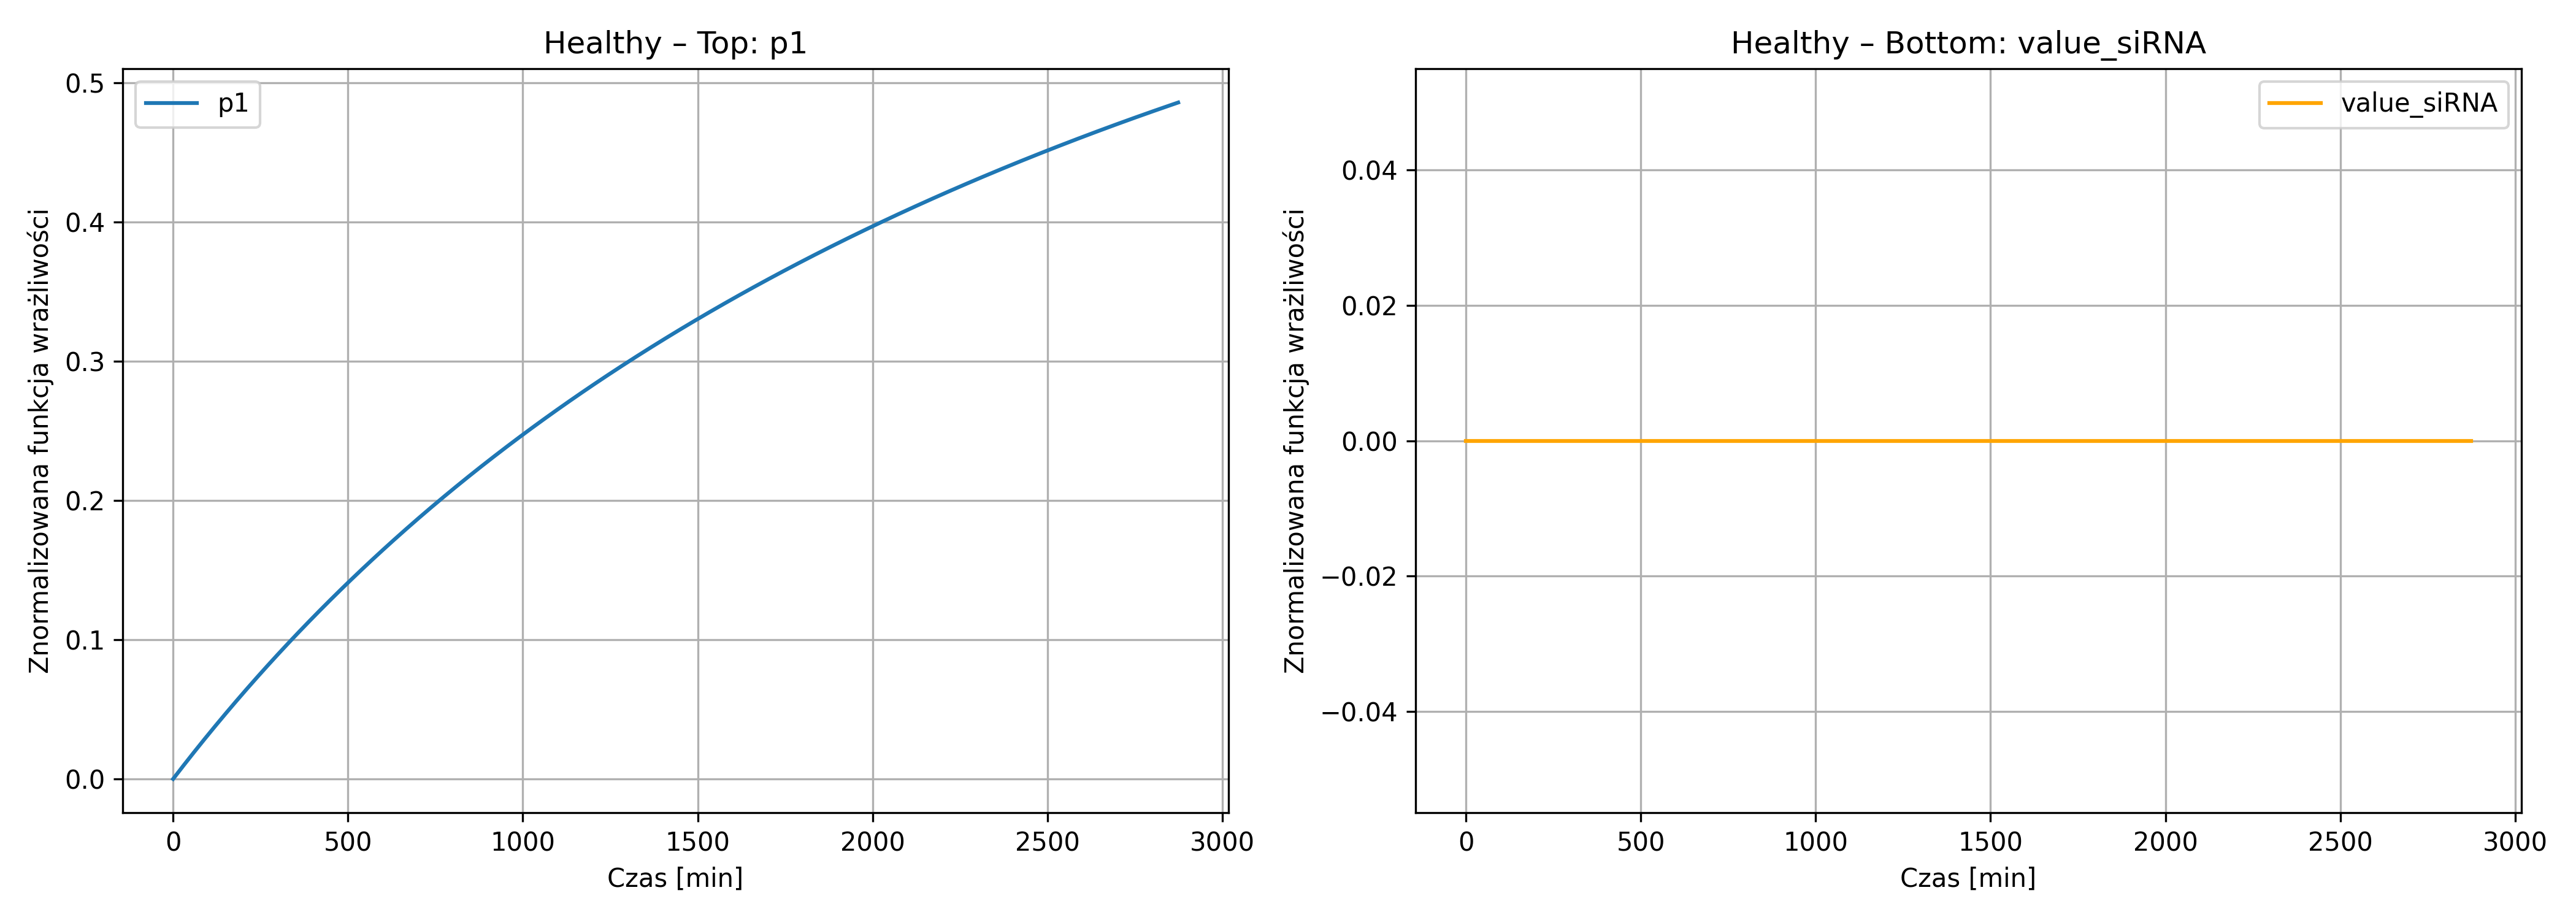
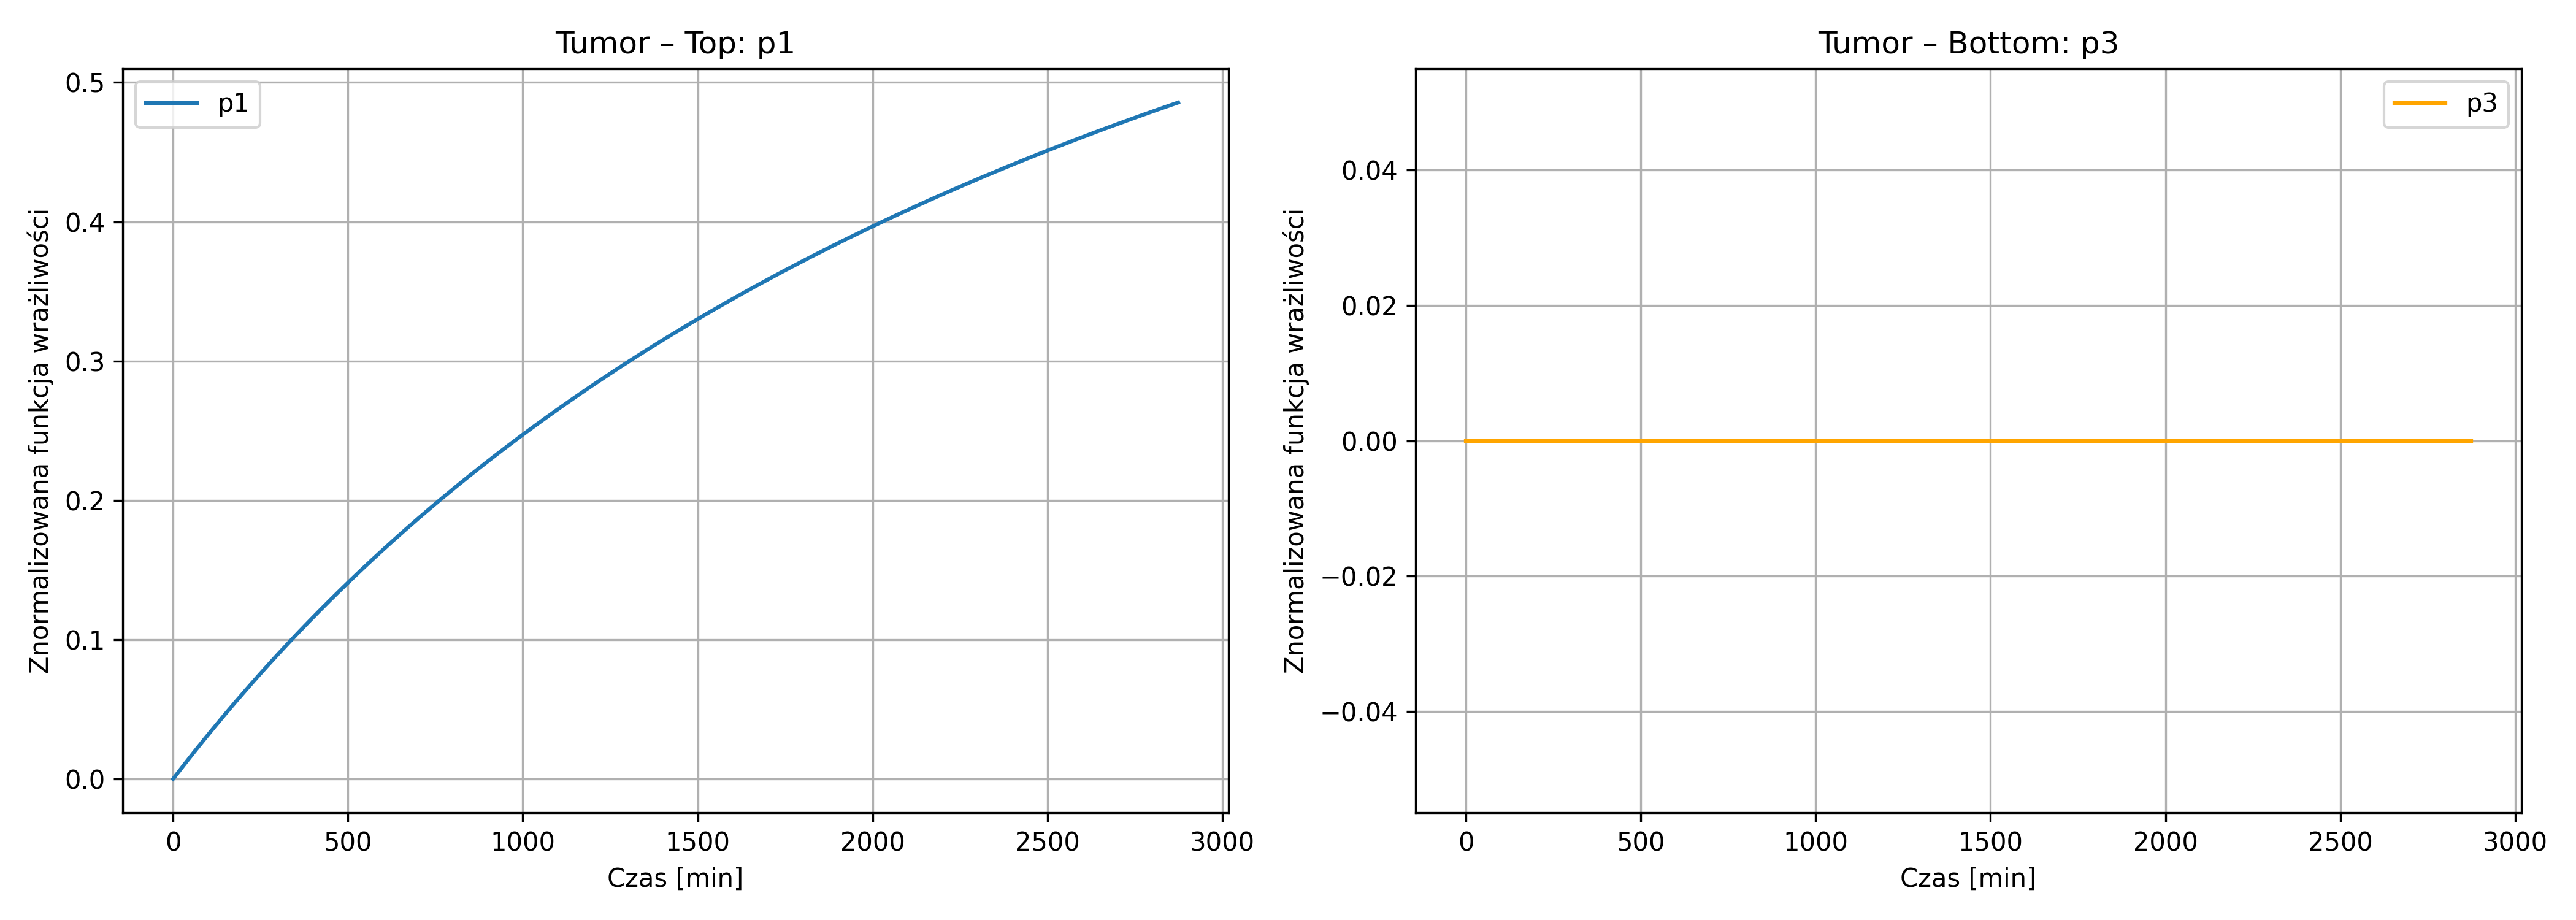
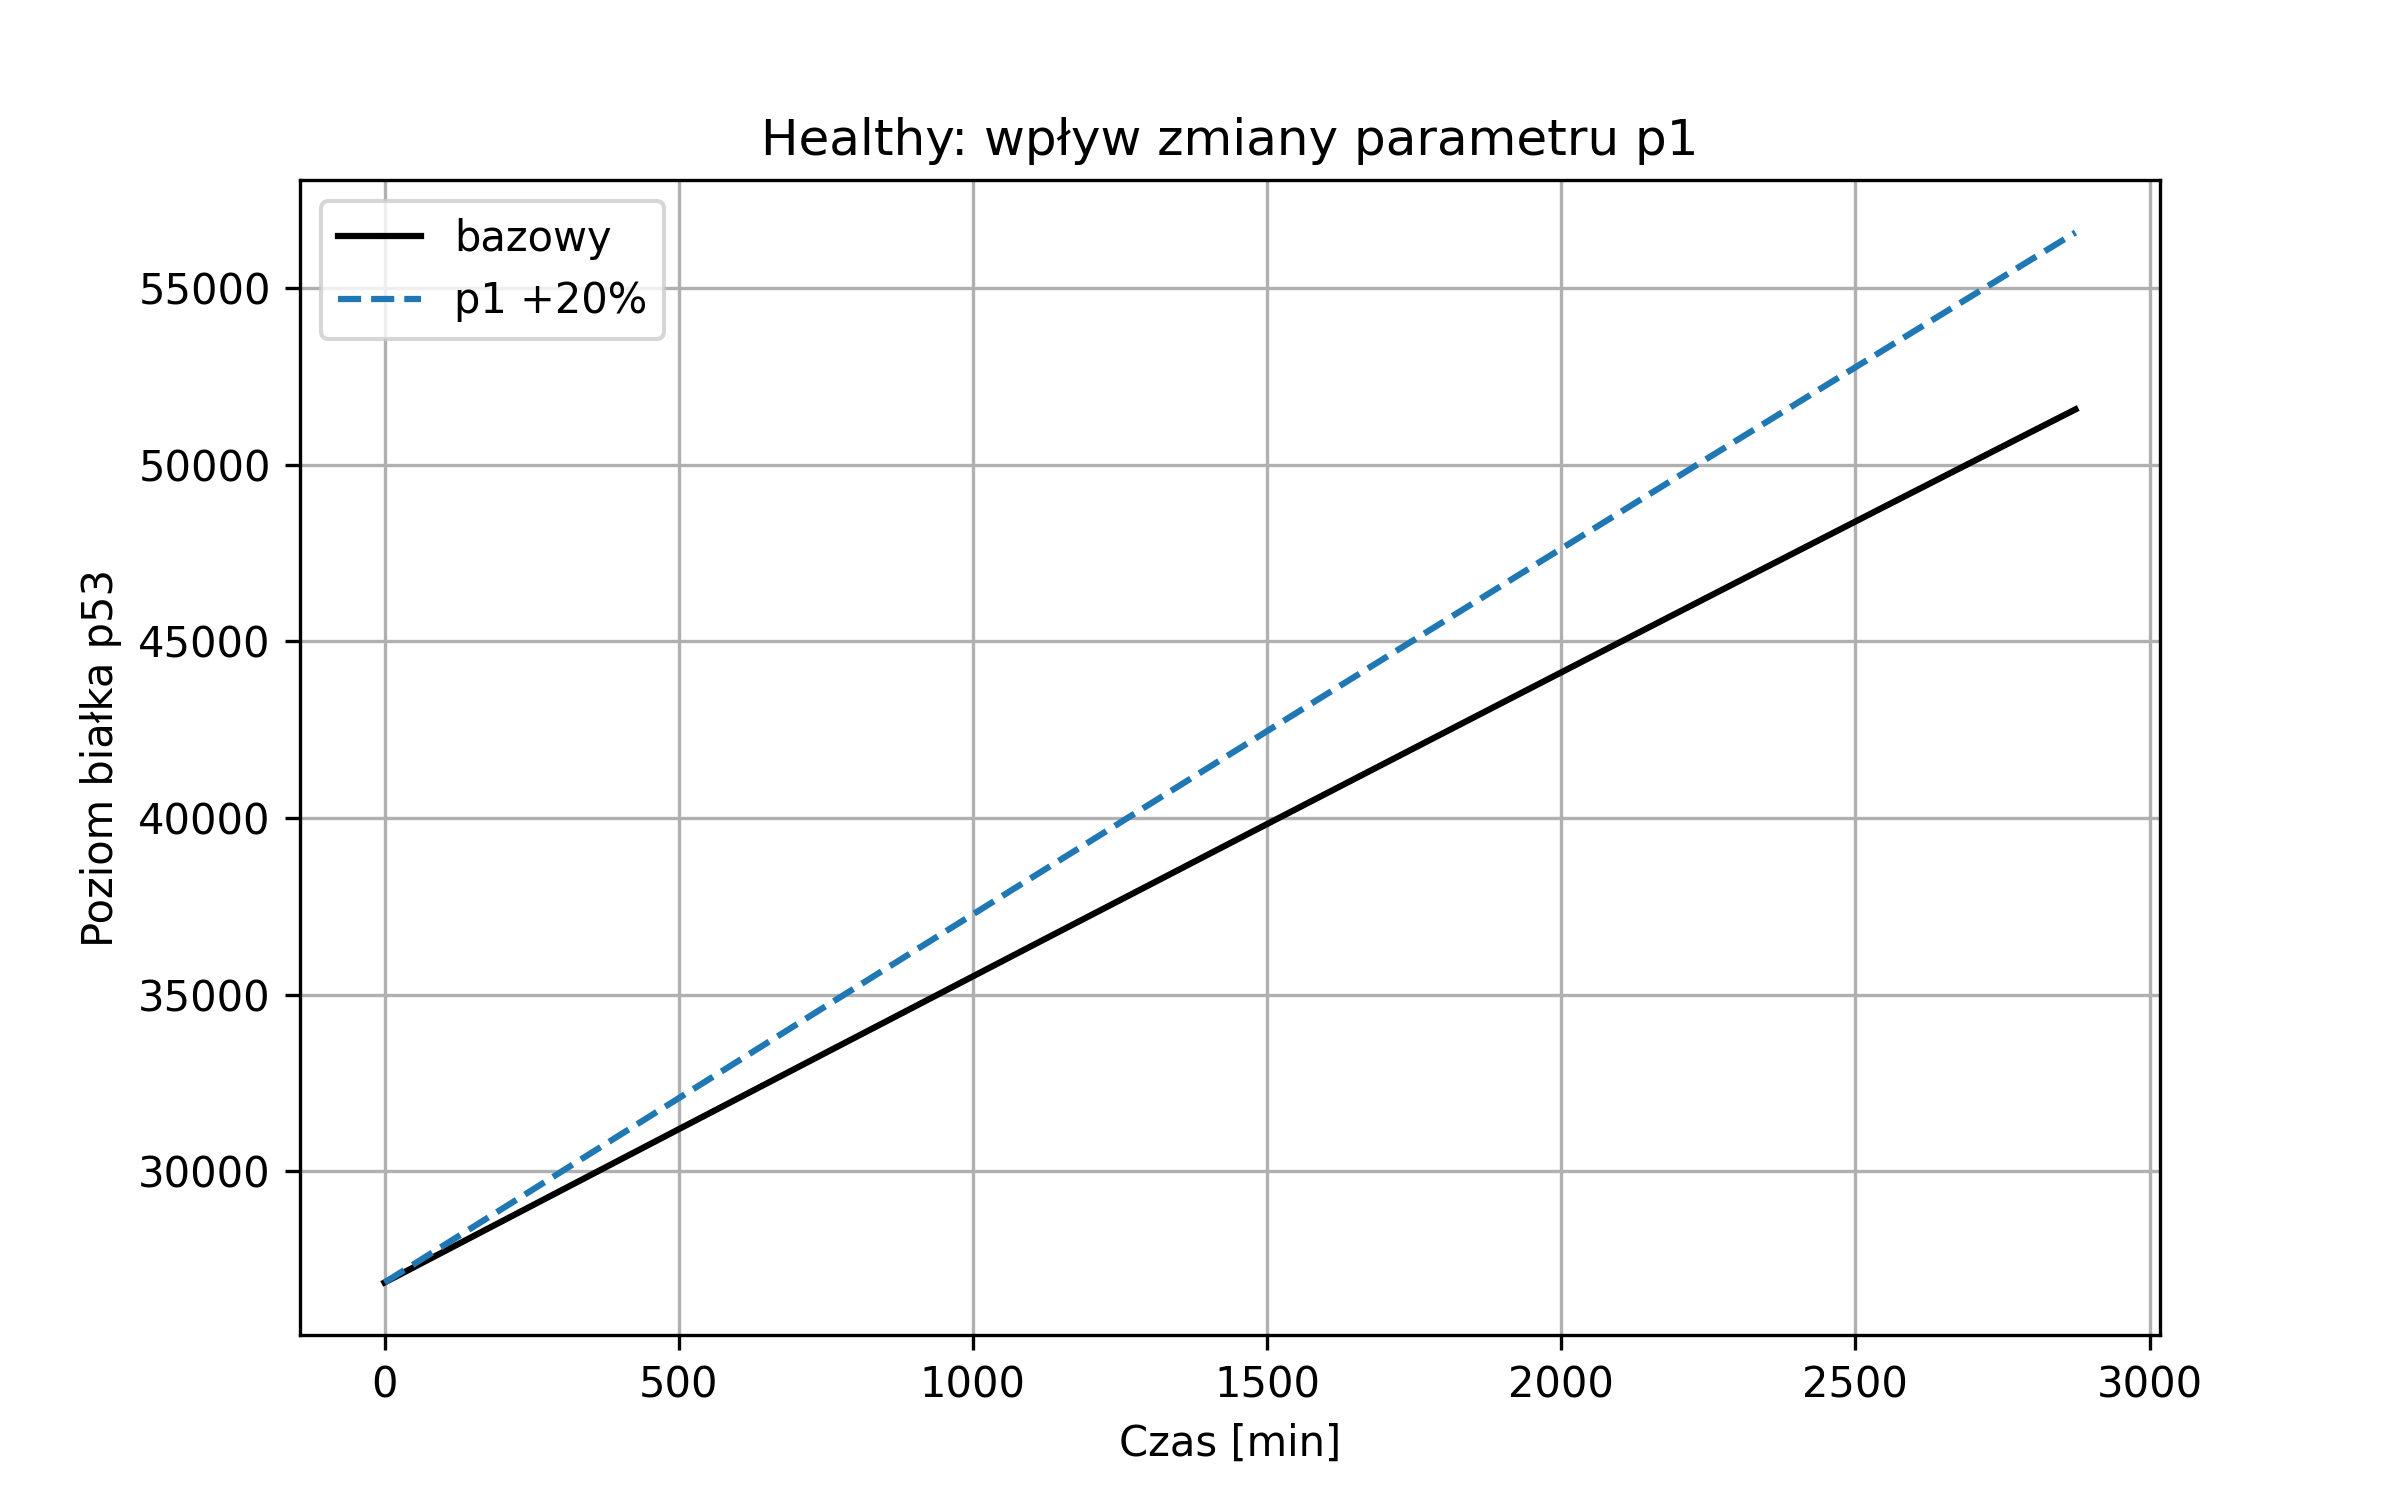
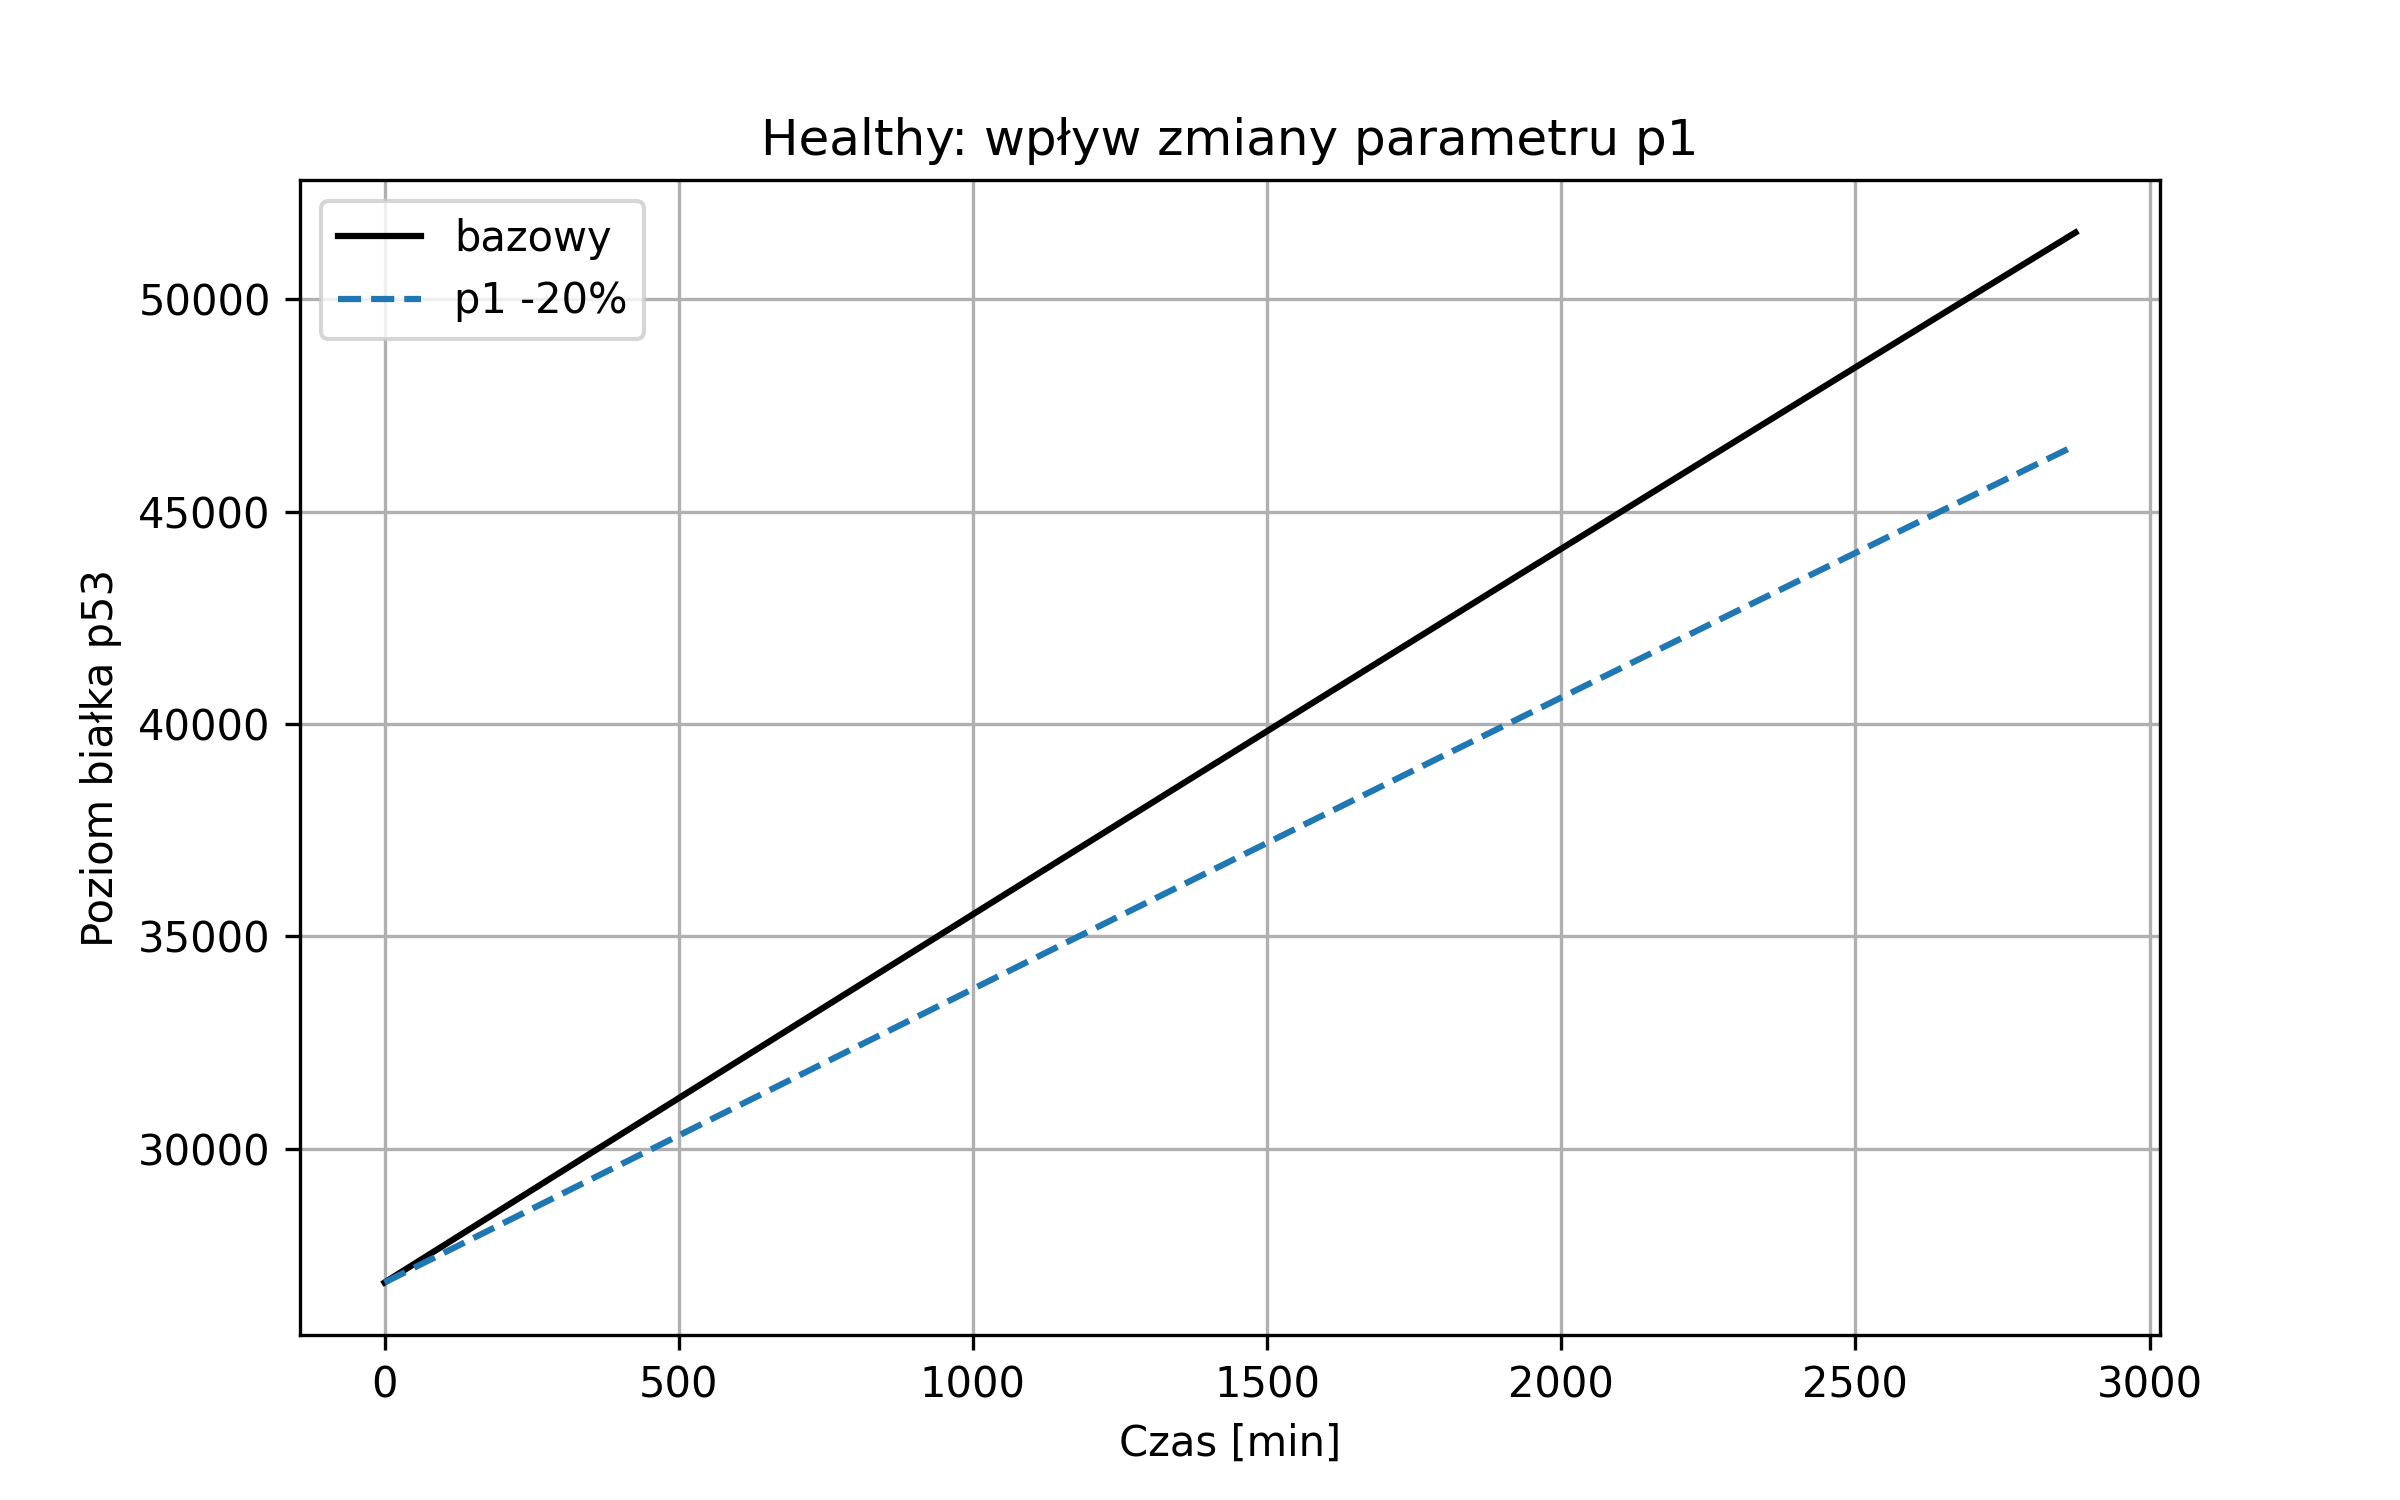
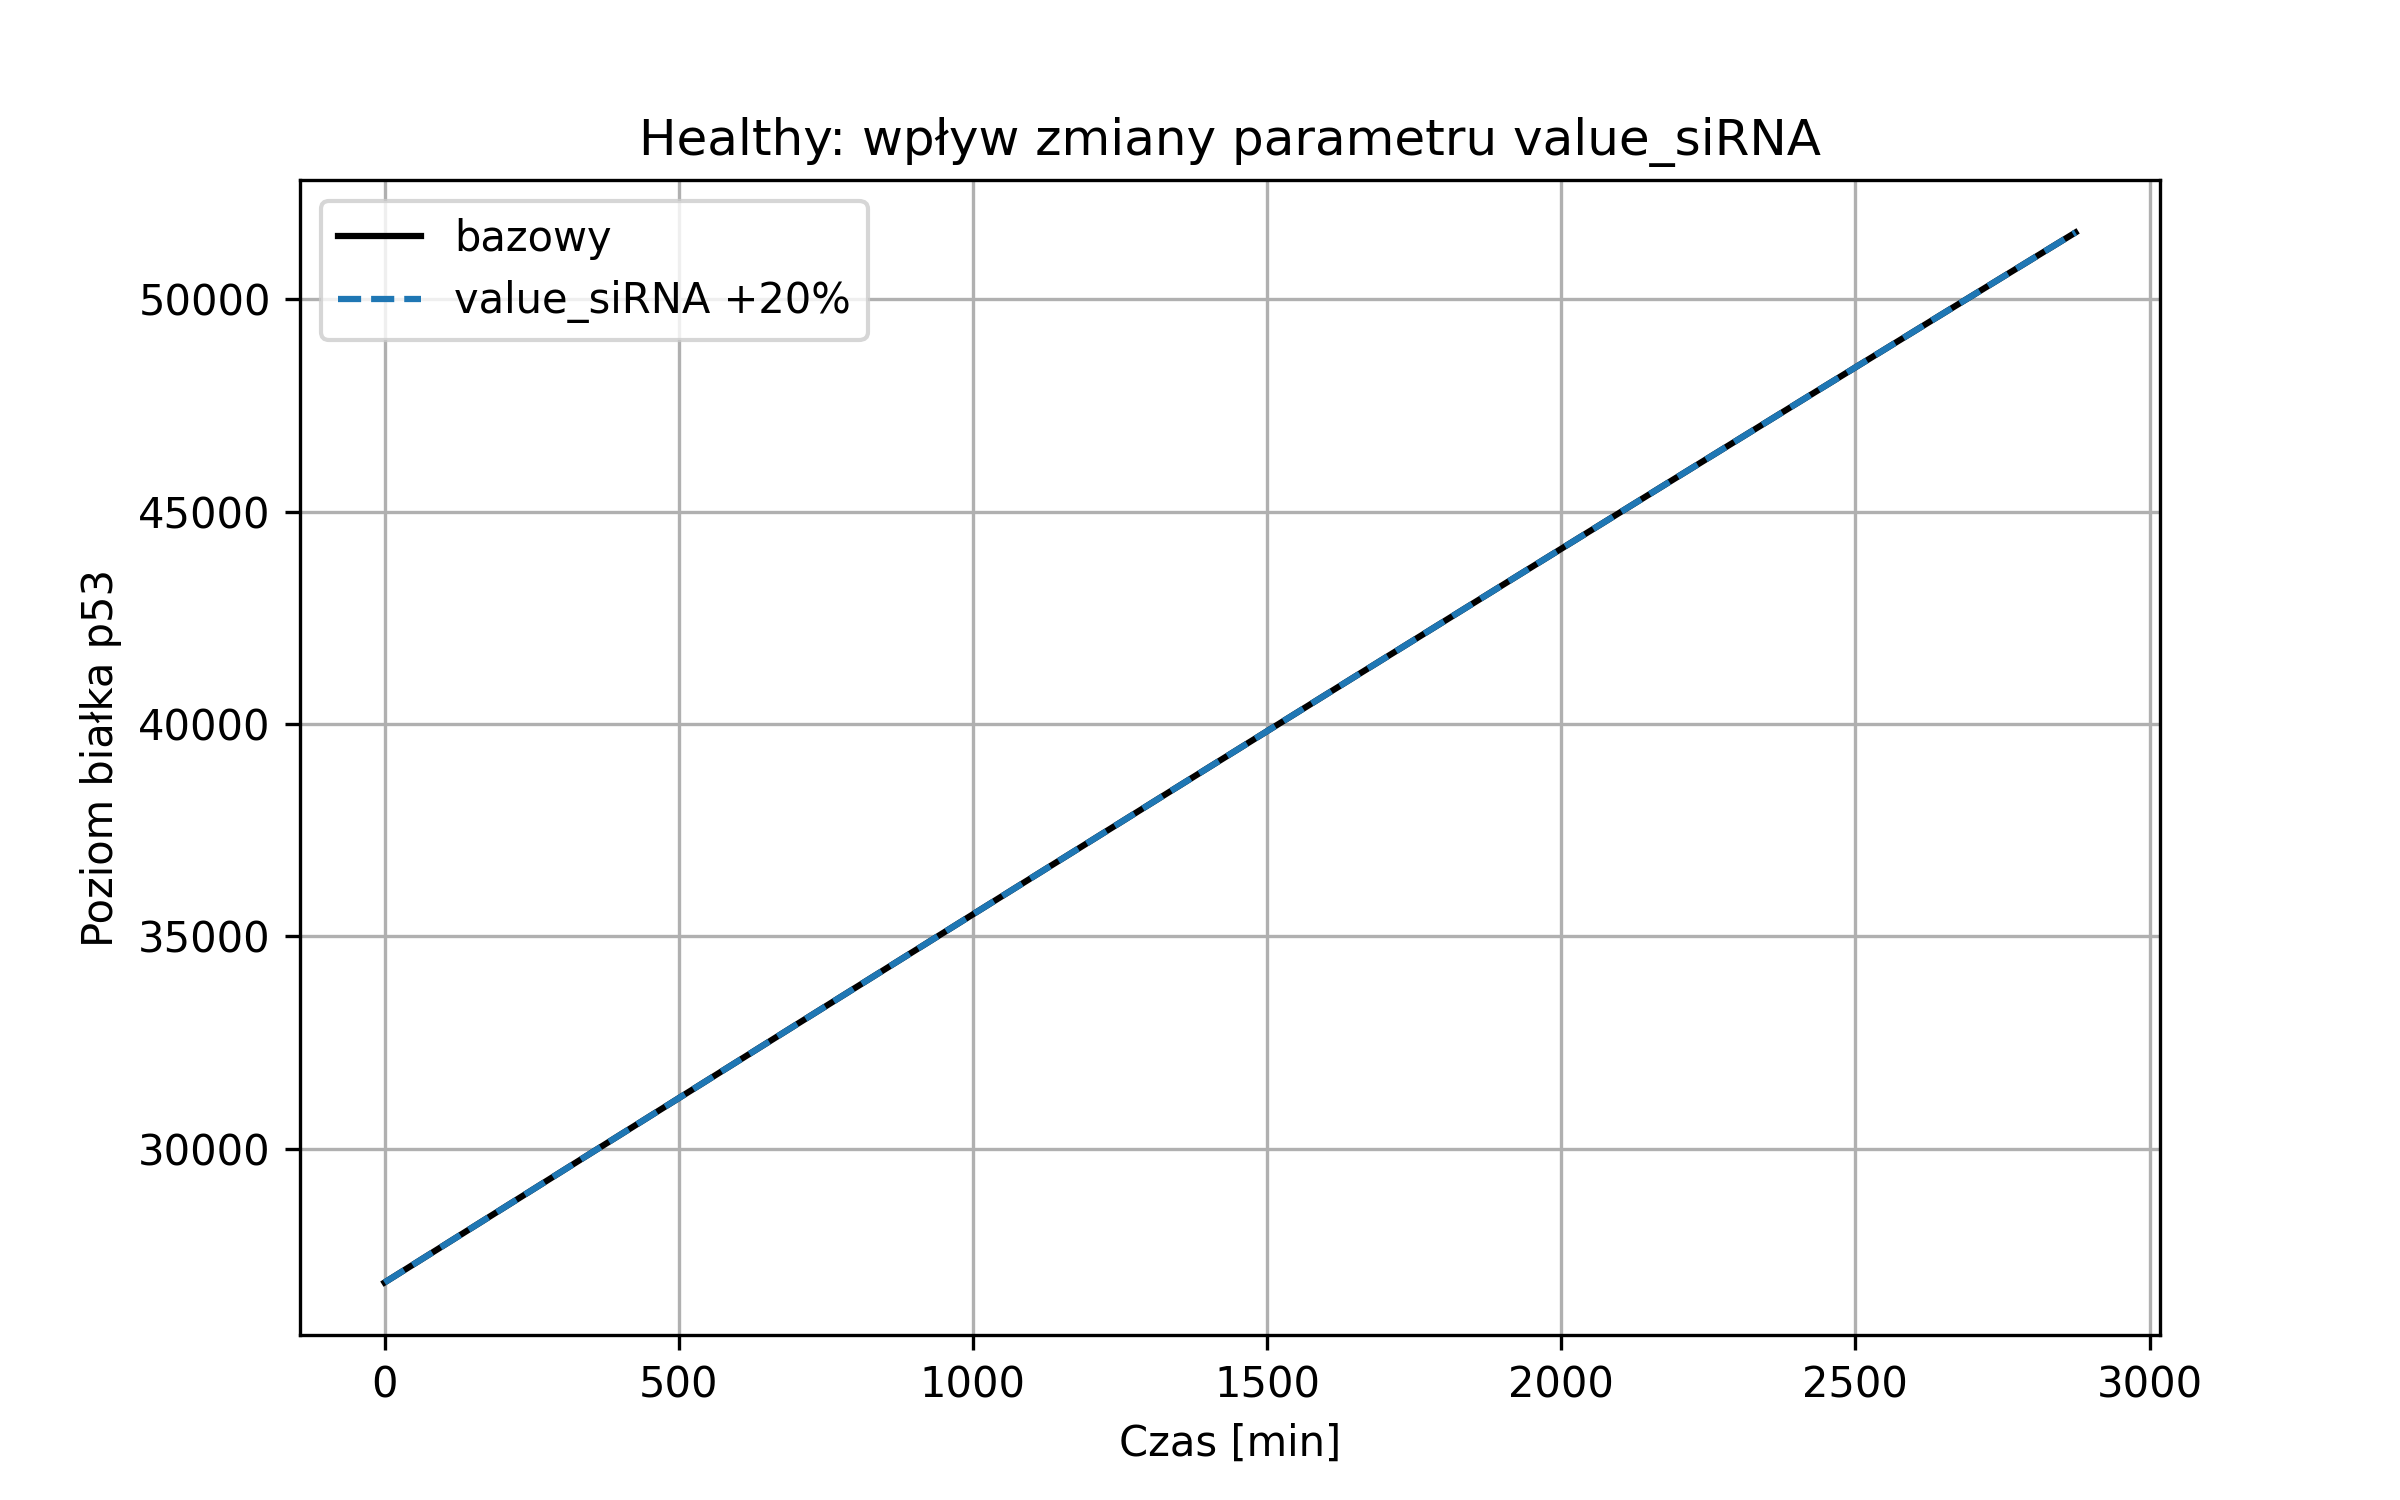
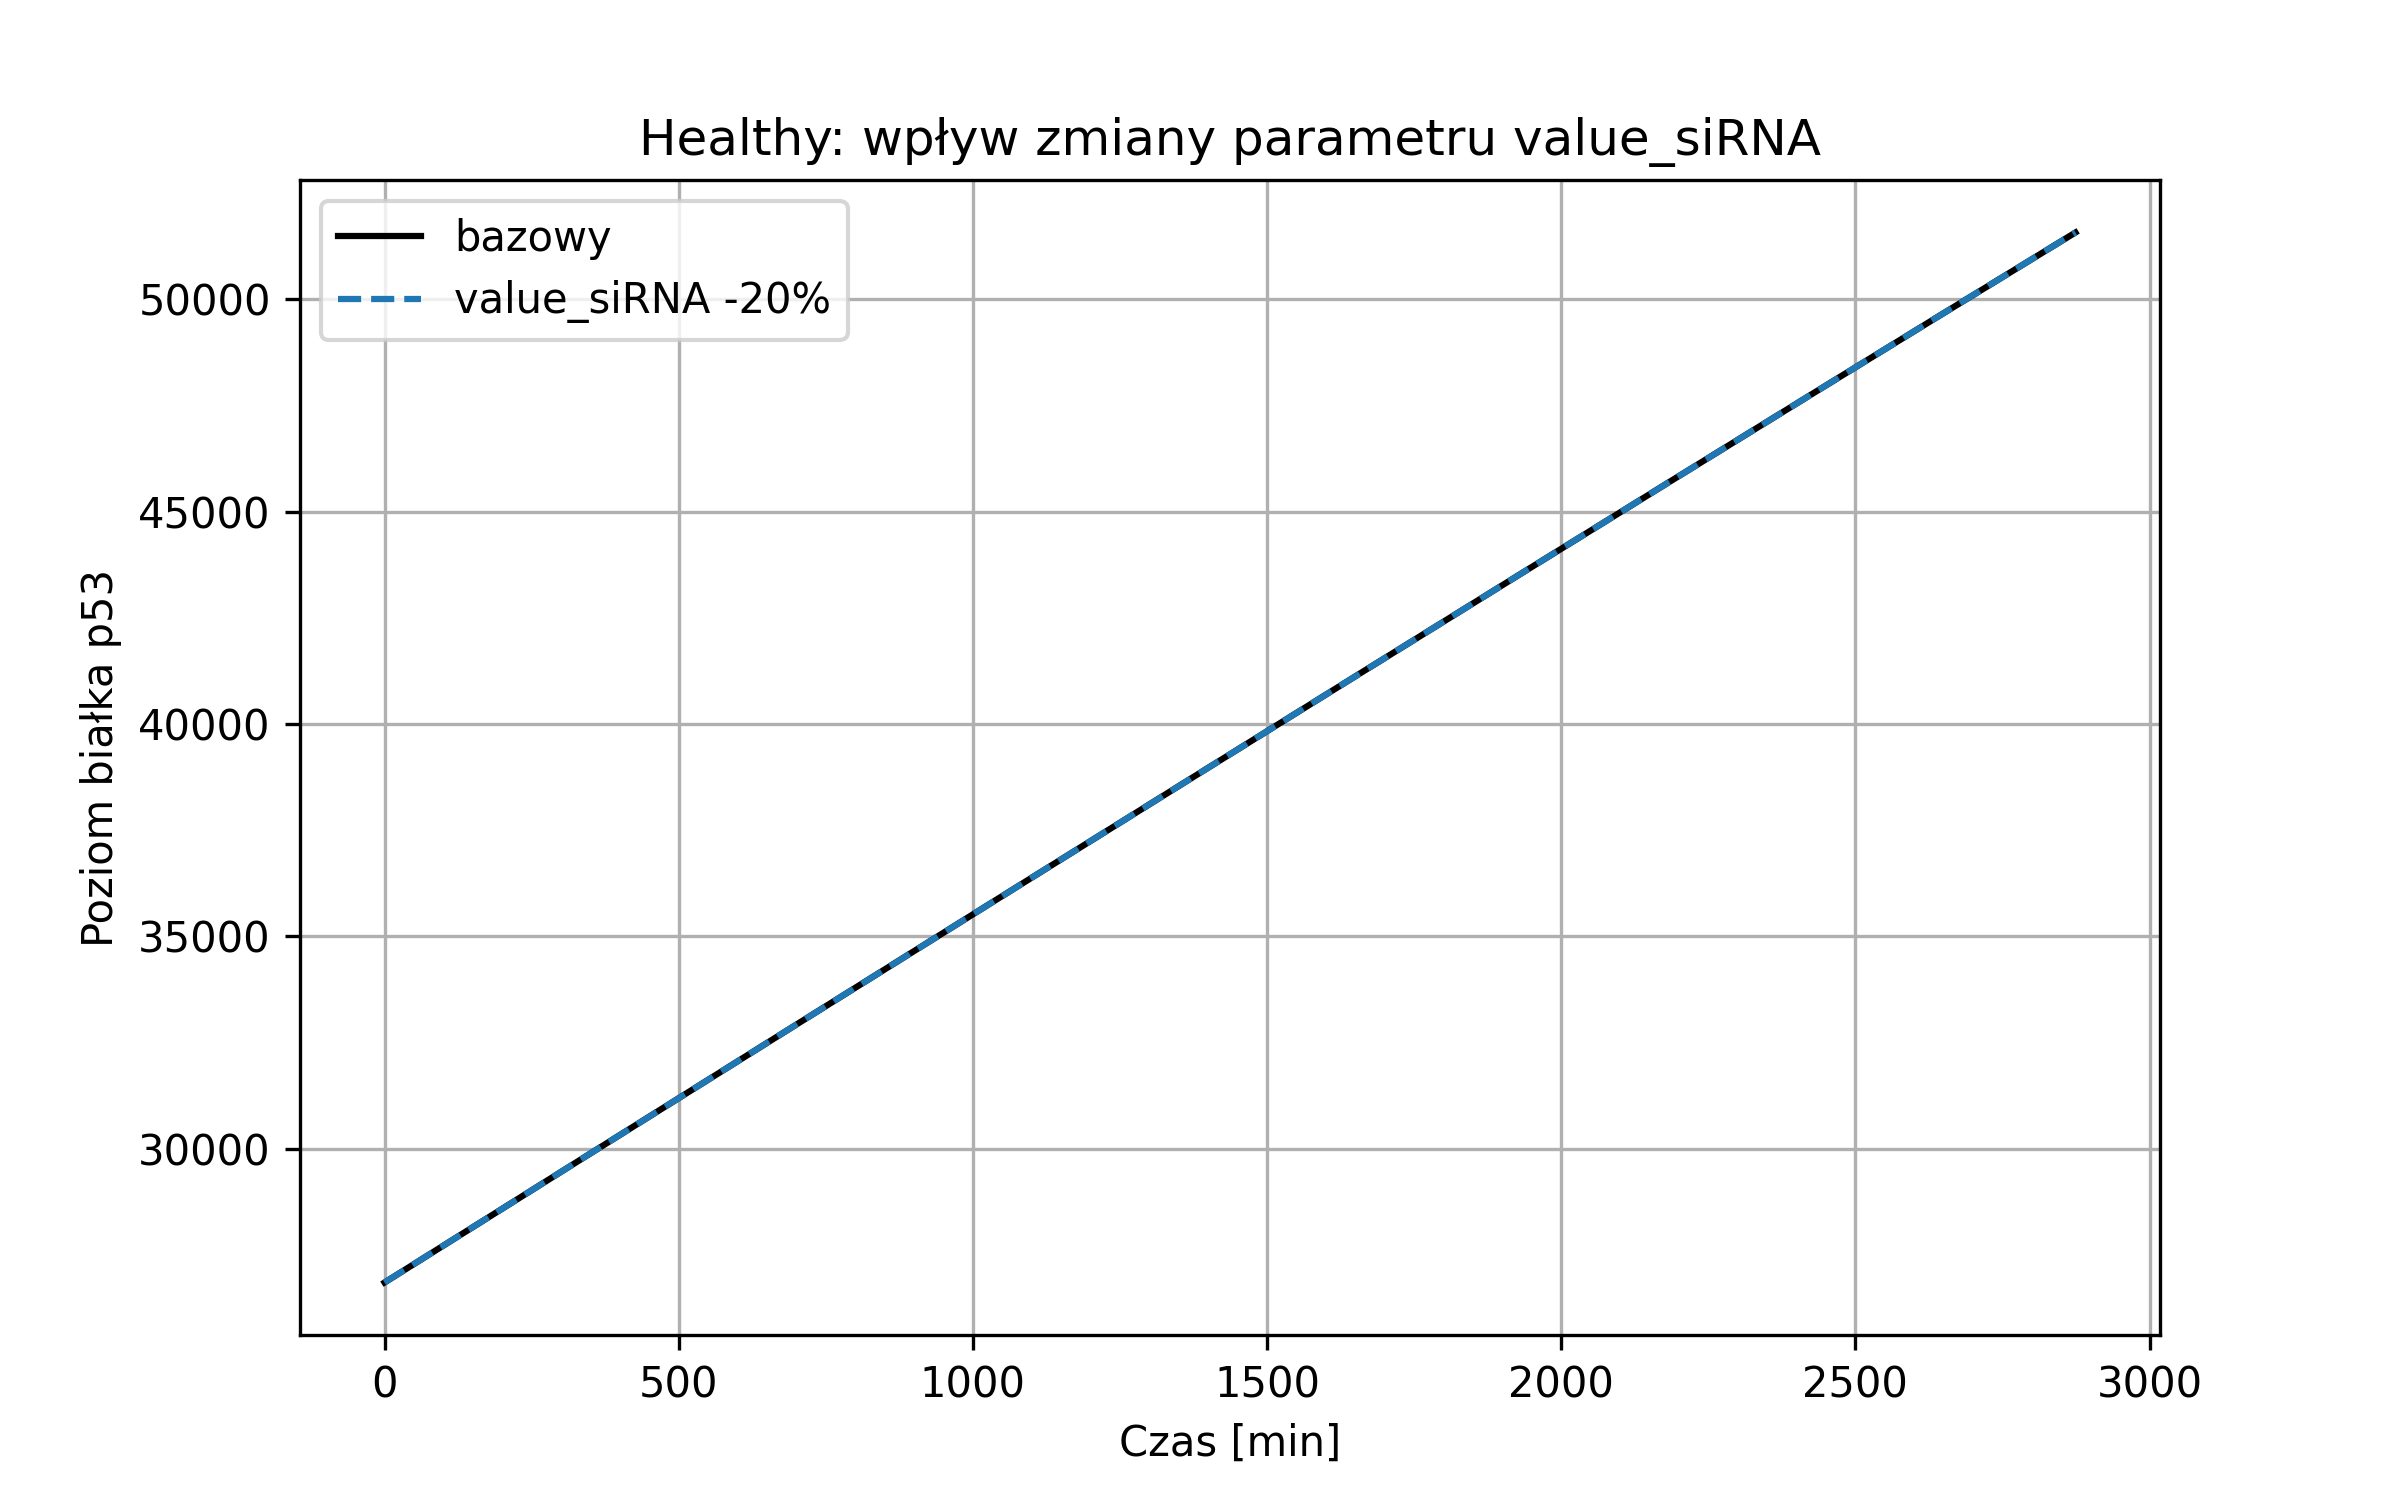
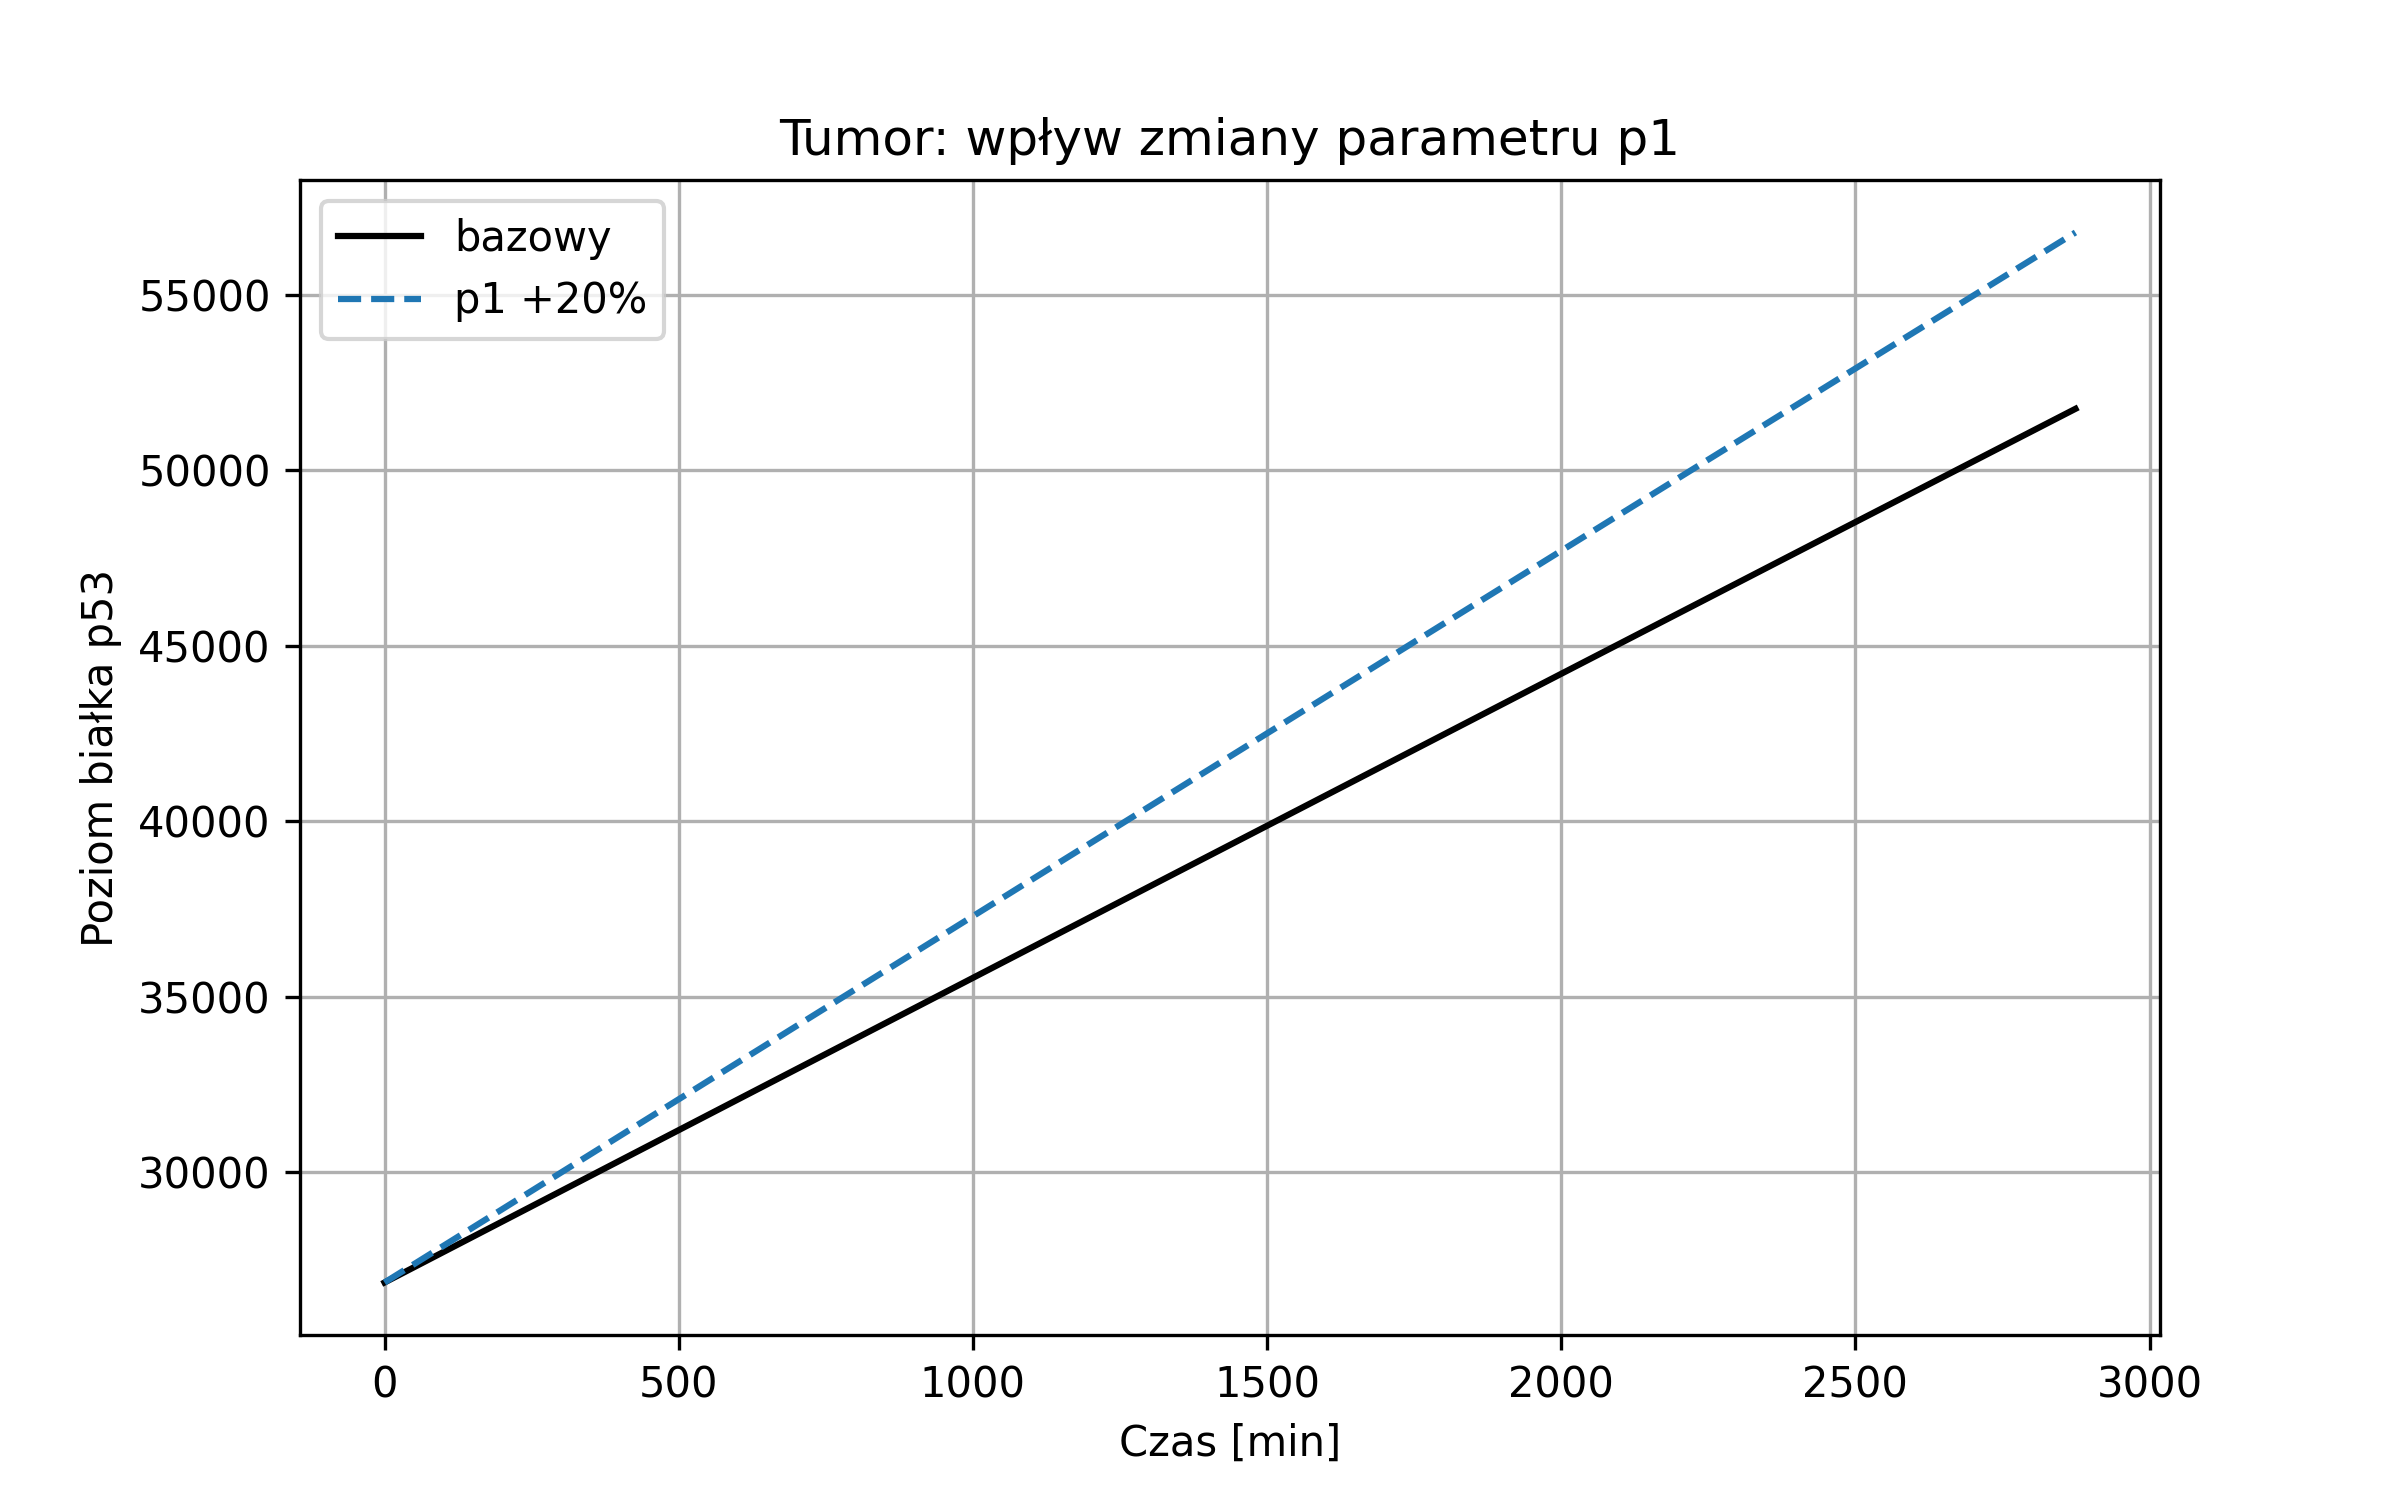
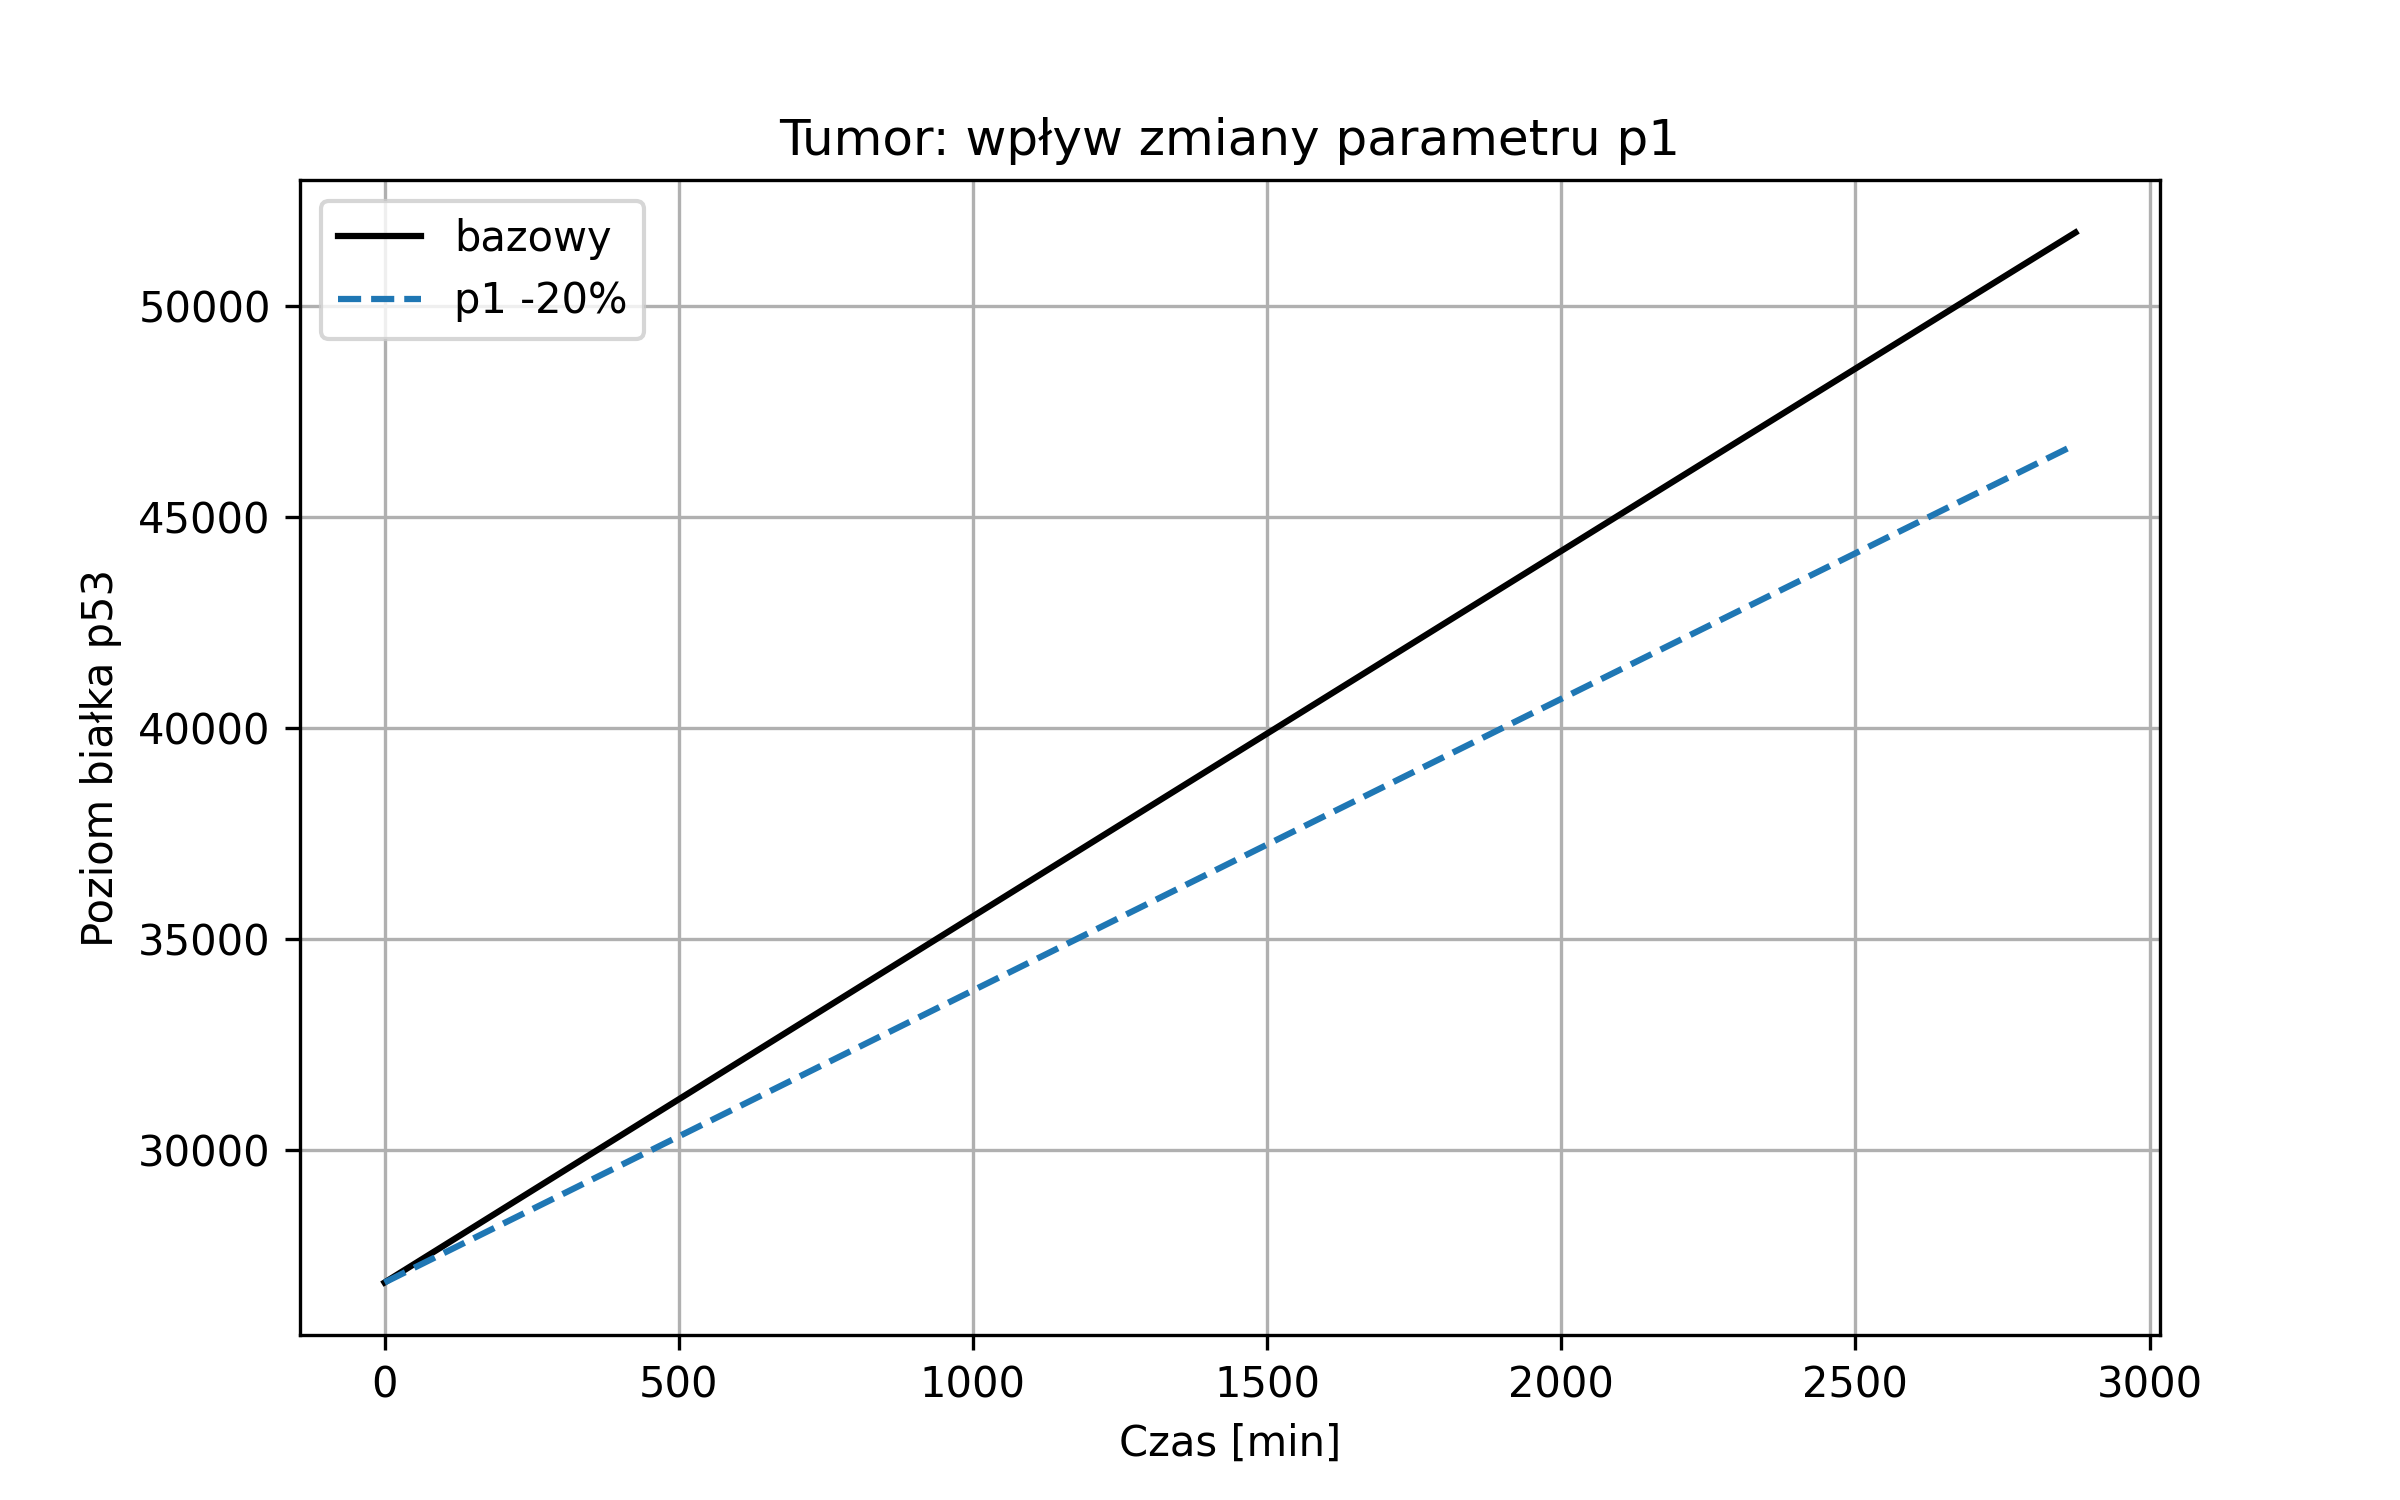
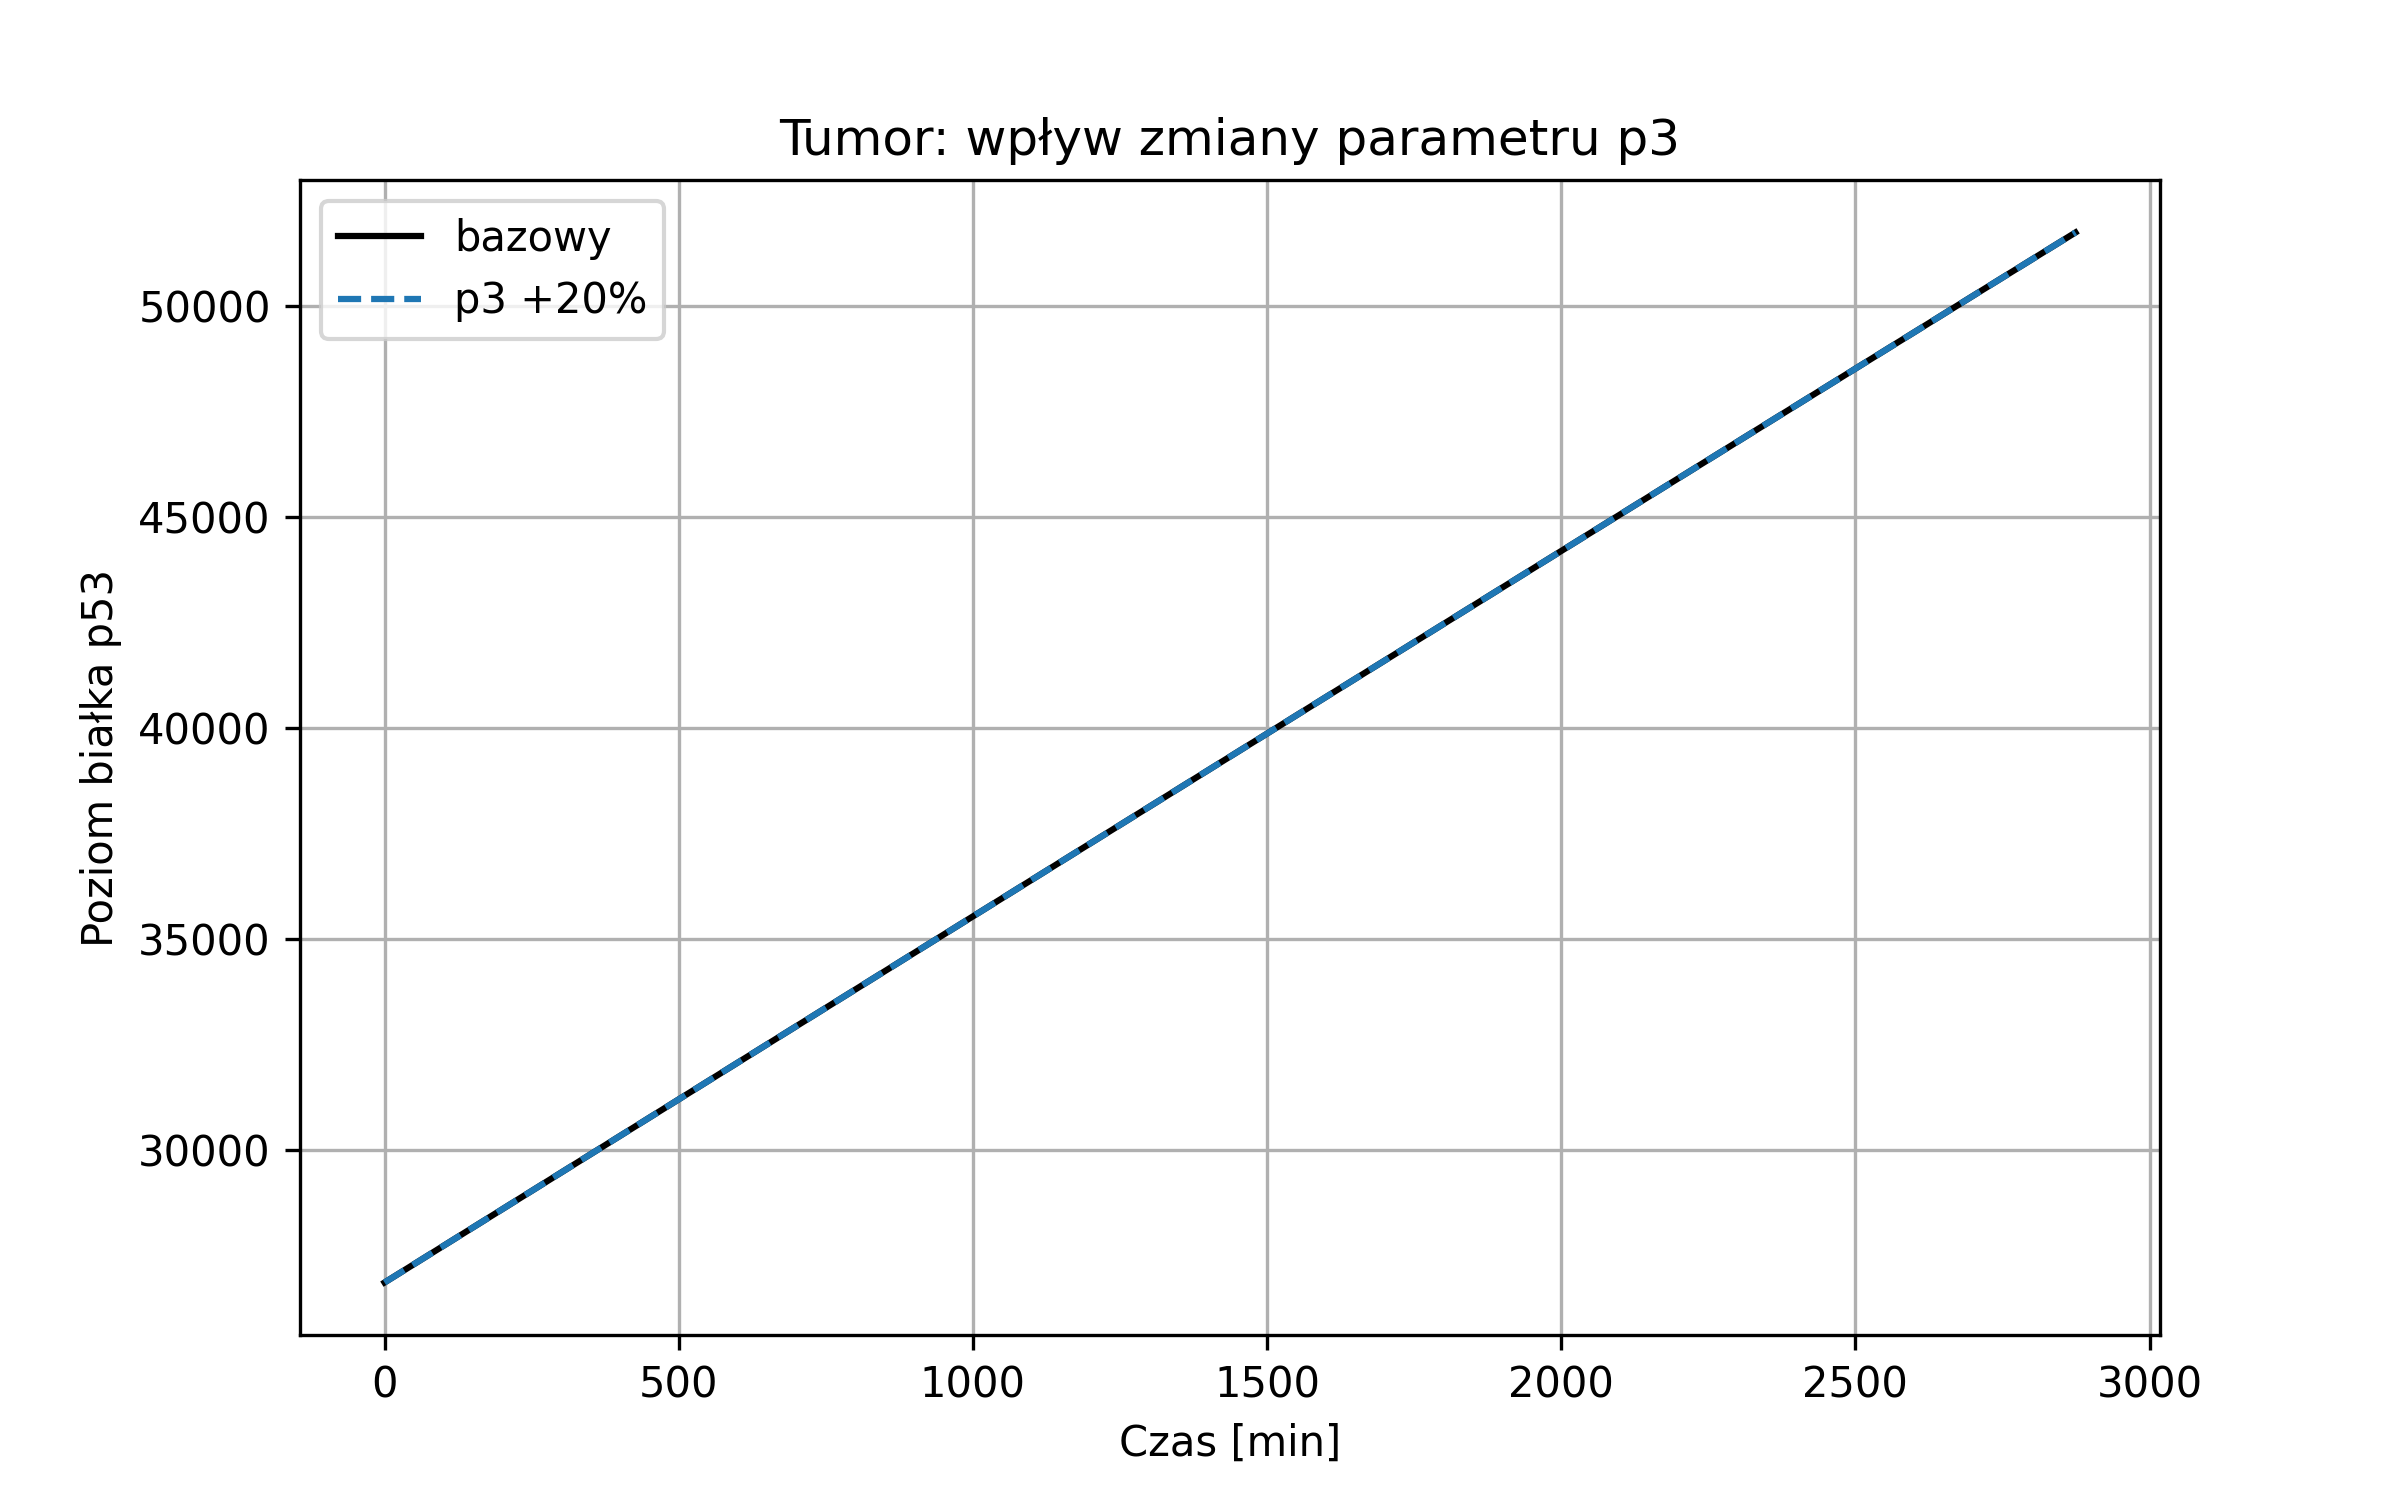
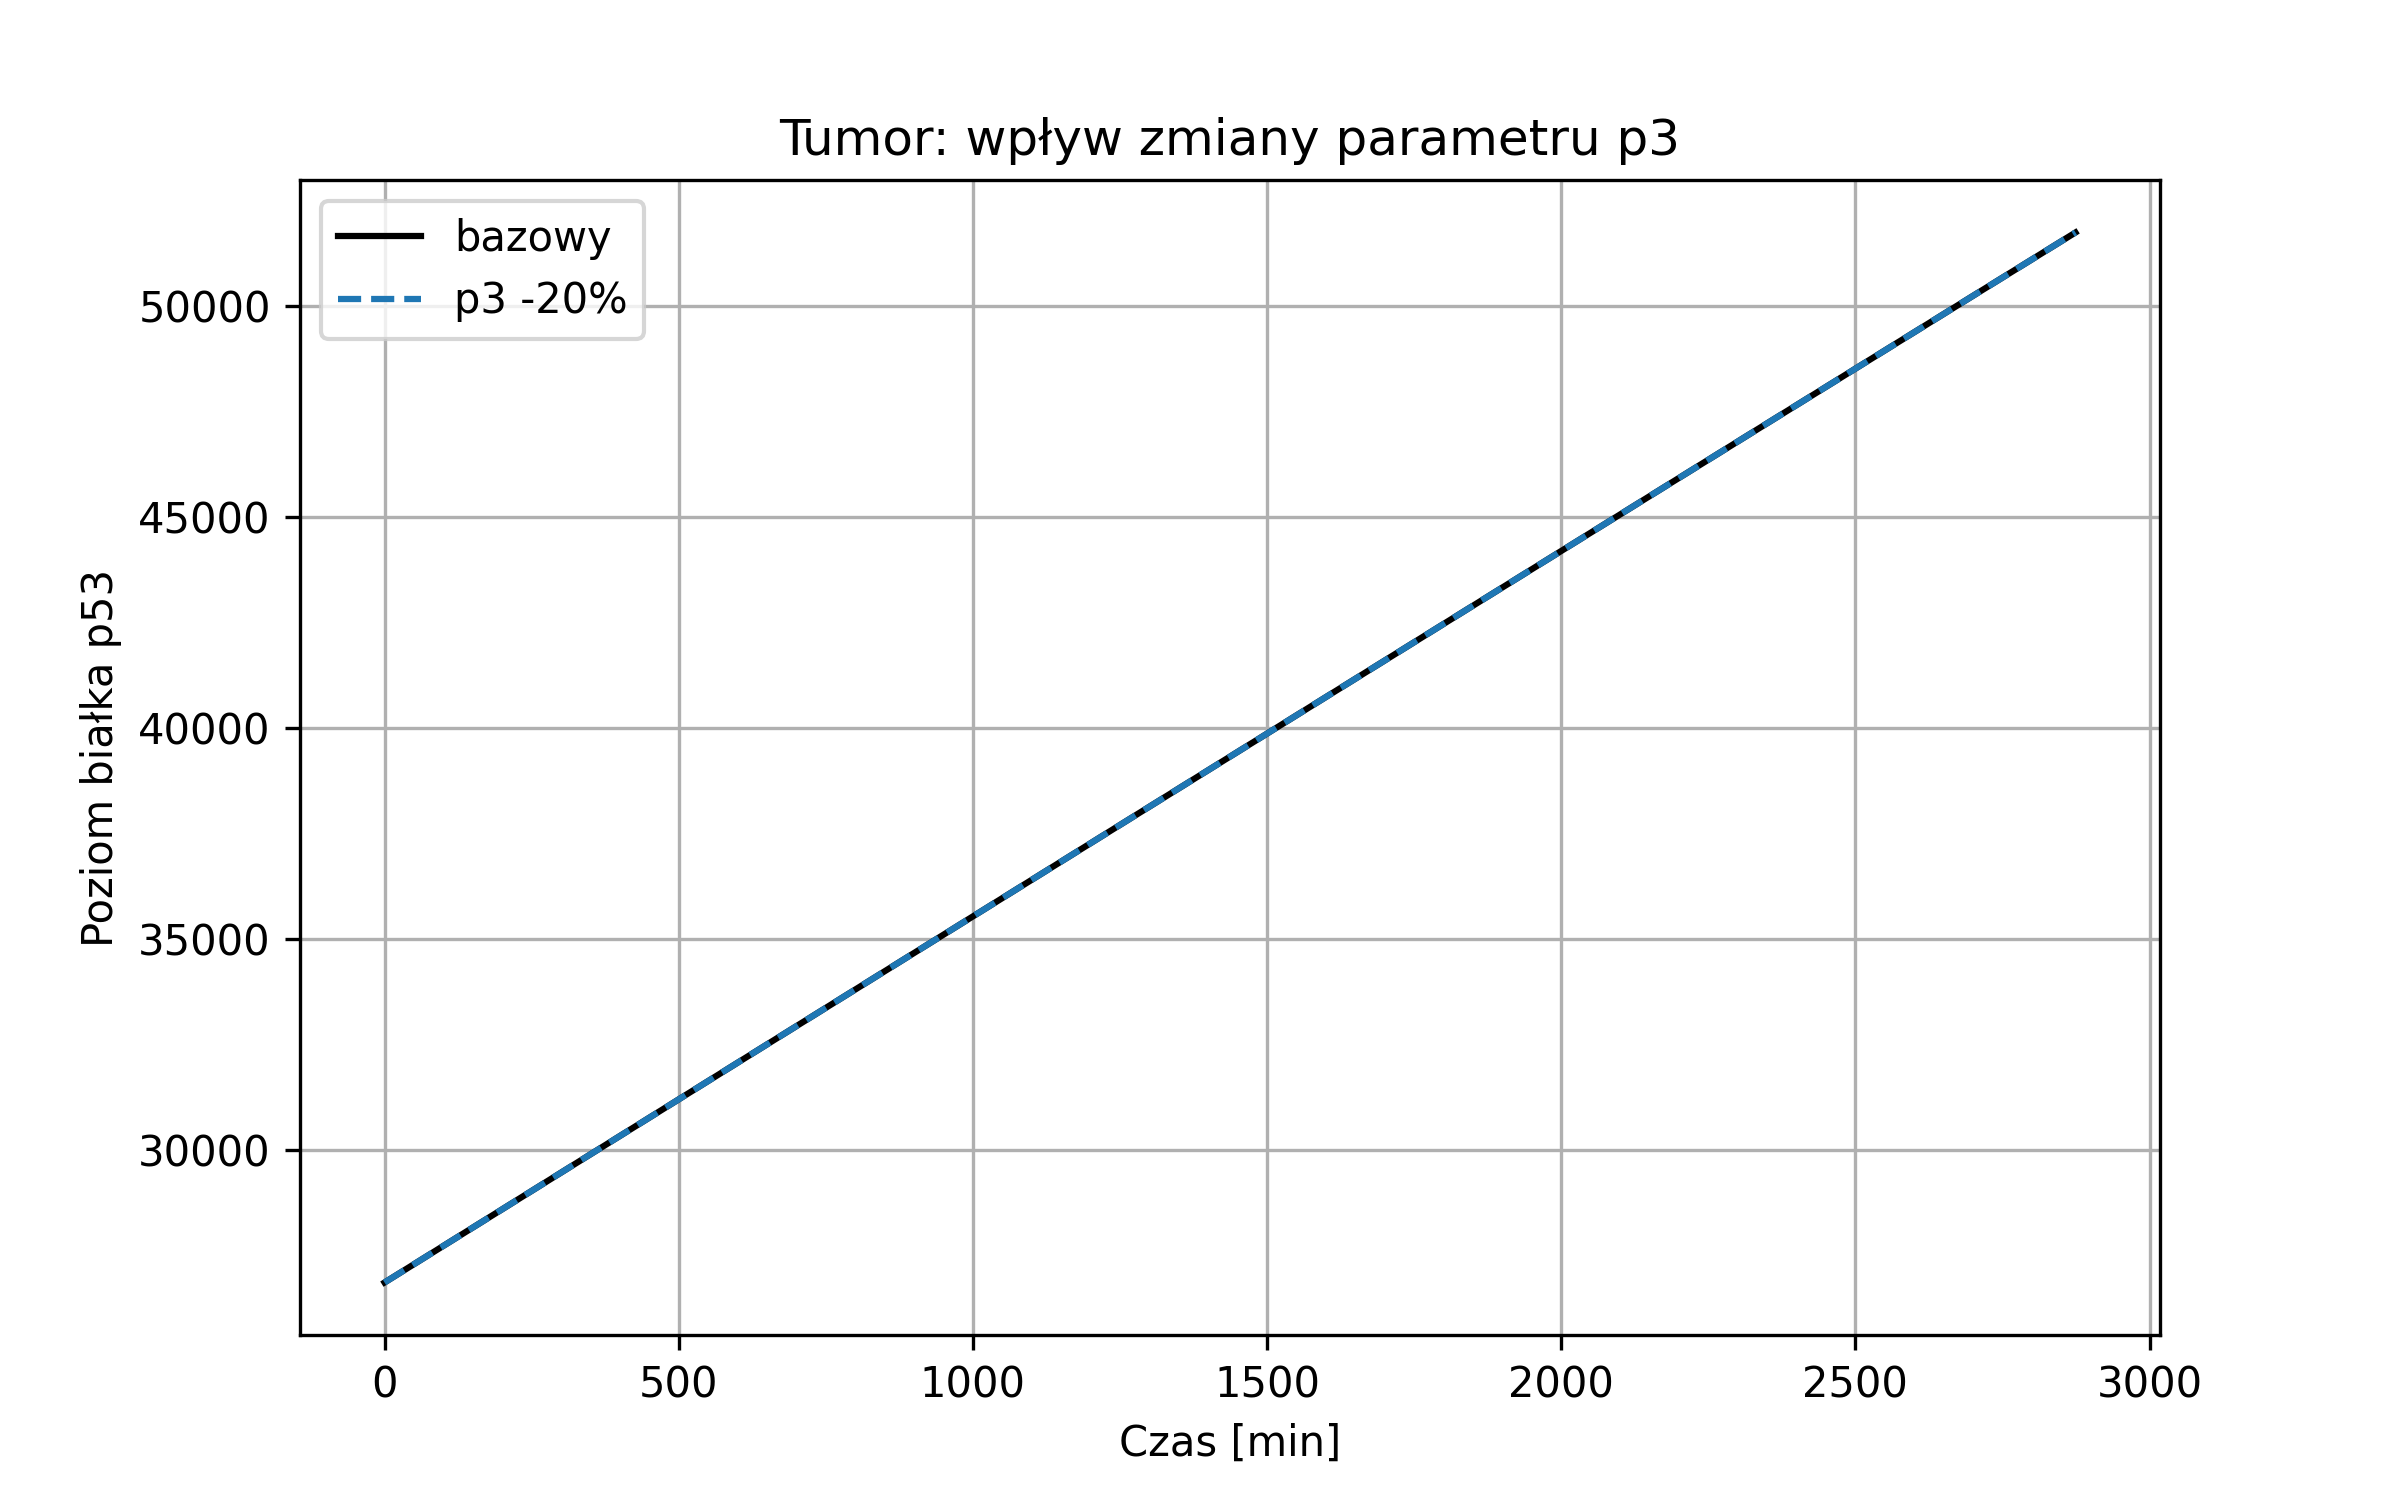

## Ranking
Ranking średni\
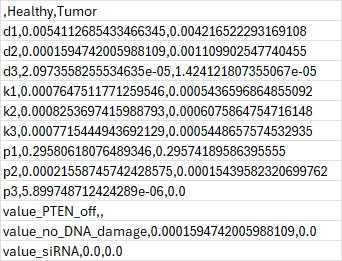\
Ranking końcowy\
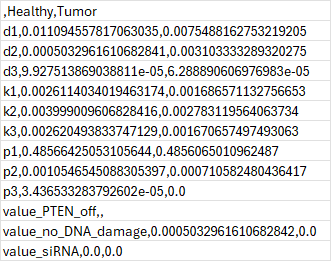


## Wnioski
Analiza lokalna wykazała, że:\
Największy wpływ na poziom białka p53 w obu scenariuszach (Healthy i Tumor) ma parametr p1, odpowiadający za produkcję białka p53.\
W scenariuszu Healthy najmniejszy wpływ miał parametr value_siRNA, który w tym przypadku był nieaktywny (siRNA = False)\
W scenariuszu Tumor najmniejszy wpływ miały parametry niezwiązane bezpośrednio z regulacją p53, np. p3 (produkcja PTEN, który był wyłączony)

Porównanie rankingów:\
Kolejność parametrów w rankingach nie była identyczna między scenariuszami.\
Różnice w pozycji w rankingach przekładały się bezpośrednio na zmiany poziomu białka p53 – co potwierdziły wykresy po zmianie parametrów o ±20%.